# Catboost Baseline

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/predict-student-performance-from-game-play/sample_submission.csv
/kaggle/input/predict-student-performance-from-game-play/train_labels.csv
/kaggle/input/predict-student-performance-from-game-play/train.csv
/kaggle/input/predict-student-performance-from-game-play/test.csv
/kaggle/input/predict-student-performance-from-game-play/jo_wilder_310/competition.cpython-310-x86_64-linux-gnu.so
/kaggle/input/predict-student-performance-from-game-play/jo_wilder_310/__init__.py
/kaggle/input/predict-student-performance-from-game-play/jo_wilder/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/predict-student-performance-from-game-play/jo_wilder/__init__.py


In [2]:
import polars as pl
import gc
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import GroupKFold, KFold
from catboost import CatBoostClassifier, Pool
import matplotlib.pyplot as plt
import warnings
from itertools import combinations
import math
from time import sleep
import pickle
import optuna
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 200)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Reading Files

In [3]:
targets = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/train_labels.csv')
targets['session'] = targets.session_id.apply(lambda x: int(x.split('_')[0]))
targets['q'] = targets.session_id.apply(lambda x: int(x.split('_')[-1][1:]))

In [4]:
columns = [
    pl.col("page").cast(pl.Float32),
    (
        (pl.col("elapsed_time") - pl.col("elapsed_time").shift(1))
        .fill_null(0)
        .clip(0, 1e9)
        .over(["session_id", "level"])
        .alias("elapsed_time_diff")
    ),
    (
        (pl.col("screen_coor_x") - pl.col("screen_coor_x").shift(1))
        .abs()
        .over(["session_id", "level"])
    ),
    (
        (pl.col("screen_coor_y") - pl.col("screen_coor_y").shift(1))
        .abs()
        .over(["session_id", "level"])
    ) ,
    pl.col("fqid").fill_null("fqid_None"),
    pl.col("text_fqid").fill_null("text_fqid_None")

]

In [5]:
dtypes = {"session_id": pl.Int64,
          "elapsed_time": pl.Int64,
          "event_name": pl.Categorical,
          "name": pl.Categorical,
          "level": pl.Int8,
          "page": pl.Float32,
          "room_coor_x": pl.Float32,
          "room_coor_y": pl.Float32,
          "screen_coor_x": pl.Float32,
          "screen_coor_y": pl.Float32,
          "hover_duration": pl.Float32,
          "fqid": pl.Categorical,
          "room_fqid": pl.Categorical,
          "fullscreen": pl.Int8,
          "hq": pl.Int8,
          "music": pl.Int8,
          "level_group": pl.Categorical
          }

In [6]:
pl.toggle_string_cache(True)

In [7]:
%%time

train = (pl.read_csv('/kaggle/input/predict-student-performance-from-game-play/train.csv',dtypes=dtypes)
                .drop(["fullscreen", "hq", "music"])
                .with_columns(columns)
        )

CPU times: user 48.5 s, sys: 20.6 s, total: 1min 9s
Wall time: 1min 9s


# Reducing training file

In [8]:
def reduce_memory_usage_pl(df, name):
    """ Reduce memory usage by polars dataframe {df} with name {name} by changing its data types.
        Original pandas version of this function: https://www.kaggle.com/code/arjanso/reducing-dataframe-memory-size-by-65 """
    print(f"Memory usage of dataframe {name} is {round(df.estimated_size('mb'), 2)} MB")
    Numeric_Int_types = [pl.Int8,pl.Int16,pl.Int32,pl.Int64]
    Numeric_Float_types = [pl.Float32,pl.Float64]    
    for col in df.columns:
        col_type = df[col].dtype
        c_min = df[col].min()
        c_max = df[col].max()
        if col_type in Numeric_Int_types:
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                df = df.with_columns(df[col].cast(pl.Int8))
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                df = df.with_columns(df[col].cast(pl.Int16))
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                df = df.with_columns(df[col].cast(pl.Int32))
            elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                df = df.with_columns(df[col].cast(pl.Int64))
        elif col_type in Numeric_Float_types:
            if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                df = df.with_columns(df[col].cast(pl.Float32))
            else:
                pass
        elif col_type == pl.Utf8:
            df = df.with_columns(df[col].cast(pl.Categorical))
        else:
            pass
    
    print(f"Memory usage of dataframe {name} became {round(df.estimated_size('mb'), 2)} MB")
    return df

In [9]:
# Reducing polar
train = reduce_memory_usage_pl(train, "train_subset")

Memory usage of dataframe train_subset is 3264.77 MB
Memory usage of dataframe train_subset became 1802.58 MB


In [10]:
df1 = train.filter(pl.col("level_group")=='0-4')
df2 = train.filter(pl.col("level_group")=='5-12')
df3 = train.filter(pl.col("level_group")=='13-22')
df1.shape,df2.shape,df3.shape

((3981005, 18), (8844238, 18), (13471703, 18))

In [11]:
df3.head(8)

shape: (8, 18)
┌──────────┬───────┬────────────┬──────────┬───┬─────────────┬────────────┬───────────┬────────────┐
│ session_ ┆ index ┆ elapsed_ti ┆ event_na ┆ … ┆ room_fqid   ┆ text_fqid  ┆ level_gro ┆ elapsed_ti │
│ id       ┆ ---   ┆ me         ┆ me       ┆   ┆ ---         ┆ ---        ┆ up        ┆ me_diff    │
│ ---      ┆ i16   ┆ ---        ┆ ---      ┆   ┆ cat         ┆ cat        ┆ ---       ┆ ---        │
│ i64      ┆       ┆ i32        ┆ cat      ┆   ┆             ┆            ┆ cat       ┆ i32        │
╞══════════╪═══════╪════════════╪══════════╪═══╪═════════════╪════════════╪═══════════╪════════════╡
│ 20090312 ┆ 512   ┆ 836732     ┆ navigate ┆ … ┆ tunic.capit ┆ text_fqid_ ┆ 13-22     ┆ 0          │
│ 43127320 ┆       ┆            ┆ _click   ┆   ┆ ol_1.hall   ┆ None       ┆           ┆            │
│ 0        ┆       ┆            ┆          ┆   ┆             ┆            ┆           ┆            │
│ 20090312 ┆ 513   ┆ 837245     ┆ navigate ┆ … ┆ tunic.capit ┆ text_fqid_ ┆ 13-22     ┆ 513        │
│ 43127320 ┆       ┆            ┆ _click   ┆   ┆ ol_1.hall   ┆ None       ┆           ┆            │
│ 0        ┆       ┆            ┆          ┆   ┆             ┆            ┆           ┆            │
│ 20090312 ┆ 514   ┆ 837779     ┆ navigate ┆ … ┆ tunic.capit ┆ text_fqid_ ┆ 13-22     ┆ 534        │
│ 43127320 ┆       ┆            ┆ _click   ┆   ┆ ol_1.hall   ┆ None       ┆           ┆            │
│ 0        ┆       ┆            ┆          ┆   ┆             ┆            ┆           ┆            │
│ 20090312 ┆ 515   ┆ 838446     ┆ navigate ┆ … ┆ tunic.capit ┆ text_fqid_ ┆ 13-22     ┆ 667        │
│ 43127320 ┆       ┆            ┆ _click   ┆   ┆ ol_1.hall   ┆ None       ┆           ┆            │
│ 0        ┆       ┆            ┆          ┆   ┆             ┆            ┆           ┆            │
│ 20090312 ┆ 516   ┆ 839629     ┆ map_hove ┆ … ┆ tunic.capit ┆ text_fqid_ ┆ 13-22     ┆ 1183       │
│ 43127320 ┆       ┆            ┆ r        ┆   ┆ ol_1.hall   ┆ None       ┆           ┆            │
│ 0        ┆       ┆            ┆          ┆   ┆             ┆            ┆           ┆            │
│ 20090312 ┆ 517   ┆ 840662     ┆ map_hove ┆ … ┆ tunic.capit ┆ text_fqid_ ┆ 13-22     ┆ 1033       │
│ 43127320 ┆       ┆            ┆ r        ┆   ┆ ol_1.hall   ┆ None       ┆           ┆            │
│ 0        ┆       ┆            ┆          ┆   ┆             ┆            ┆           ┆            │
│ 20090312 ┆ 518   ┆ 840780     ┆ map_hove ┆ … ┆ tunic.capit ┆ text_fqid_ ┆ 13-22     ┆ 118        │
│ 43127320 ┆       ┆            ┆ r        ┆   ┆ ol_1.hall   ┆ None       ┆           ┆            │
│ 0        ┆       ┆            ┆          ┆   ┆             ┆            ┆           ┆            │
│ 20090312 ┆ 519   ┆ 840830     ┆ map_hove ┆ … ┆ tunic.capit ┆ text_fqid_ ┆ 13-22     ┆ 50         │
│ 43127320 ┆       ┆            ┆ r        ┆   ┆ ol_1.hall   ┆ None       ┆           ┆            │
│ 0        ┆       ┆            ┆          ┆   ┆             ┆            ┆           ┆            │
└──────────┴───────┴────────────┴──────────┴───┴─────────────┴────────────┴───────────┴────────────┘

In [12]:
#Delete train to liberate memory
del train
gc.collect()

30

# Feature Engineering

In [13]:
CATS = ['event_name', 'name', 'fqid', 'room_fqid', 'text_fqid']
NUMS = ['page', 'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y',
        'hover_duration', 'elapsed_time_diff']

fqid_lists = ['worker', 'archivist', 'gramps', 'wells', 'toentry', 'confrontation', 'crane_ranger', 'groupconvo', 'flag_girl', 'tomap', 'tostacks', 'tobasement', 'archivist_glasses', 'boss', 'journals', 'seescratches', 'groupconvo_flag', 'cs', 'teddy', 'expert', 'businesscards', 'ch3start', 'tunic.historicalsociety', 'tofrontdesk', 'savedteddy', 'plaque', 'glasses', 'tunic.drycleaner', 'reader_flag', 'tunic.library', 'tracks', 'tunic.capitol_2', 'trigger_scarf', 'reader', 'directory', 'tunic.capitol_1', 'journals.pic_0.next', 'unlockdoor', 'tunic', 'what_happened', 'tunic.kohlcenter', 'tunic.humanecology', 'colorbook', 'logbook', 'businesscards.card_0.next', 'journals.hub.topics', 'logbook.page.bingo', 'journals.pic_1.next', 'journals_flag', 'reader.paper0.next', 'tracks.hub.deer', 'reader_flag.paper0.next', 'trigger_coffee', 'wellsbadge', 'journals.pic_2.next', 'tomicrofiche', 'journals_flag.pic_0.bingo', 'plaque.face.date', 'notebook', 'tocloset_dirty', 'businesscards.card_bingo.bingo', 'businesscards.card_1.next', 'tunic.wildlife', 'tunic.hub.slip', 'tocage', 'journals.pic_2.bingo', 'tocollectionflag', 'tocollection', 'chap4_finale_c', 'chap2_finale_c', 'lockeddoor', 'journals_flag.hub.topics', 'tunic.capitol_0', 'reader_flag.paper2.bingo', 'photo', 'tunic.flaghouse', 'reader.paper1.next', 'directory.closeup.archivist', 'intro', 'businesscards.card_bingo.next', 'reader.paper2.bingo', 'retirement_letter', 'remove_cup', 'journals_flag.pic_0.next', 'magnify', 'coffee', 'key', 'togrampa', 'reader_flag.paper1.next', 'janitor', 'tohallway', 'chap1_finale', 'report', 'outtolunch', 'journals_flag.hub.topics_old', 'journals_flag.pic_1.next', 'reader.paper2.next', 'chap1_finale_c', 'reader_flag.paper2.next', 'door_block_talk', 'journals_flag.pic_1.bingo', 'journals_flag.pic_2.next', 'journals_flag.pic_2.bingo', 'block_magnify', 'reader.paper0.prev', 'block', 'reader_flag.paper0.prev', 'block_0', 'door_block_clean', 'reader.paper2.prev', 'reader.paper1.prev', 'doorblock', 'tocloset', 'reader_flag.paper2.prev', 'reader_flag.paper1.prev', 'block_tomap2', 'journals_flag.pic_0_old.next', 'journals_flag.pic_1_old.next', 'block_tocollection', 'block_nelson', 'journals_flag.pic_2_old.next', 'block_tomap1', 'block_badge', 'need_glasses', 'block_badge_2', 'fox', 'block_1']
DIALOGS = ['that', 'this', 'it', 'you','find','found','Found','notebook','Wells','wells','help','need', 'Oh','Ooh','Jo', 'flag', 'can','and','is','the','to']

name_feature = ['basic', 'undefined', 'close', 'open', 'prev', 'next']
event_name_feature = ['cutscene_click', 'person_click', 'navigate_click',
       'observation_click', 'notification_click', 'object_click',
       'object_hover', 'map_hover', 'map_click', 'checkpoint',
       'notebook_click']

text_lists = ['tunic.historicalsociety.cage.confrontation', 'tunic.wildlife.center.crane_ranger.crane', 'tunic.historicalsociety.frontdesk.archivist.newspaper', 'tunic.historicalsociety.entry.groupconvo', 'tunic.wildlife.center.wells.nodeer', 'tunic.historicalsociety.frontdesk.archivist.have_glass', 'tunic.drycleaner.frontdesk.worker.hub', 'tunic.historicalsociety.closet_dirty.gramps.news', 'tunic.humanecology.frontdesk.worker.intro', 'tunic.historicalsociety.frontdesk.archivist_glasses.confrontation', 'tunic.historicalsociety.basement.seescratches', 'tunic.historicalsociety.collection.cs', 'tunic.flaghouse.entry.flag_girl.hello', 'tunic.historicalsociety.collection.gramps.found', 'tunic.historicalsociety.basement.ch3start', 'tunic.historicalsociety.entry.groupconvo_flag', 'tunic.library.frontdesk.worker.hello', 'tunic.library.frontdesk.worker.wells', 'tunic.historicalsociety.collection_flag.gramps.flag', 'tunic.historicalsociety.basement.savedteddy', 'tunic.library.frontdesk.worker.nelson', 'tunic.wildlife.center.expert.removed_cup', 'tunic.library.frontdesk.worker.flag', 'tunic.historicalsociety.frontdesk.archivist.hello', 'tunic.historicalsociety.closet.gramps.intro_0_cs_0', 'tunic.historicalsociety.entry.boss.flag', 'tunic.flaghouse.entry.flag_girl.symbol', 'tunic.historicalsociety.closet_dirty.trigger_scarf', 'tunic.drycleaner.frontdesk.worker.done', 'tunic.historicalsociety.closet_dirty.what_happened', 'tunic.wildlife.center.wells.animals', 'tunic.historicalsociety.closet.teddy.intro_0_cs_0', 'tunic.historicalsociety.cage.glasses.afterteddy', 'tunic.historicalsociety.cage.teddy.trapped', 'tunic.historicalsociety.cage.unlockdoor', 'tunic.historicalsociety.stacks.journals.pic_2.bingo', 'tunic.historicalsociety.entry.wells.flag', 'tunic.humanecology.frontdesk.worker.badger', 'tunic.historicalsociety.stacks.journals_flag.pic_0.bingo', 'tunic.historicalsociety.closet.intro', 'tunic.historicalsociety.closet.retirement_letter.hub', 'tunic.historicalsociety.entry.directory.closeup.archivist', 'tunic.historicalsociety.collection.tunic.slip', 'tunic.kohlcenter.halloffame.plaque.face.date', 'tunic.historicalsociety.closet_dirty.trigger_coffee', 'tunic.drycleaner.frontdesk.logbook.page.bingo', 'tunic.library.microfiche.reader.paper2.bingo', 'tunic.kohlcenter.halloffame.togrampa', 'tunic.capitol_2.hall.boss.haveyougotit', 'tunic.wildlife.center.wells.nodeer_recap', 'tunic.historicalsociety.cage.glasses.beforeteddy', 'tunic.historicalsociety.closet_dirty.gramps.helpclean', 'tunic.wildlife.center.expert.recap', 'tunic.historicalsociety.frontdesk.archivist.have_glass_recap', 'tunic.historicalsociety.stacks.journals_flag.pic_1.bingo', 'tunic.historicalsociety.cage.lockeddoor', 'tunic.historicalsociety.stacks.journals_flag.pic_2.bingo', 'tunic.historicalsociety.collection.gramps.lost', 'tunic.historicalsociety.closet.notebook', 'tunic.historicalsociety.frontdesk.magnify', 'tunic.humanecology.frontdesk.businesscards.card_bingo.bingo', 'tunic.wildlife.center.remove_cup', 'tunic.library.frontdesk.wellsbadge.hub', 'tunic.wildlife.center.tracks.hub.deer', 'tunic.historicalsociety.frontdesk.key', 'tunic.library.microfiche.reader_flag.paper2.bingo', 'tunic.flaghouse.entry.colorbook', 'tunic.wildlife.center.coffee', 'tunic.capitol_1.hall.boss.haveyougotit', 'tunic.historicalsociety.basement.janitor', 'tunic.historicalsociety.collection_flag.gramps.recap', 'tunic.wildlife.center.wells.animals2', 'tunic.flaghouse.entry.flag_girl.symbol_recap', 'tunic.historicalsociety.closet_dirty.photo', 'tunic.historicalsociety.stacks.outtolunch', 'tunic.library.frontdesk.worker.wells_recap', 'tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_recap', 'tunic.capitol_0.hall.boss.talktogramps', 'tunic.historicalsociety.closet.photo', 'tunic.historicalsociety.collection.tunic', 'tunic.historicalsociety.closet.teddy.intro_0_cs_5', 'tunic.historicalsociety.closet_dirty.gramps.archivist', 'tunic.historicalsociety.closet_dirty.door_block_talk', 'tunic.historicalsociety.entry.boss.flag_recap', 'tunic.historicalsociety.frontdesk.archivist.need_glass_0', 'tunic.historicalsociety.entry.wells.talktogramps', 'tunic.historicalsociety.frontdesk.block_magnify', 'tunic.historicalsociety.frontdesk.archivist.foundtheodora', 'tunic.historicalsociety.closet_dirty.gramps.nothing', 'tunic.historicalsociety.closet_dirty.door_block_clean', 'tunic.capitol_1.hall.boss.writeitup', 'tunic.library.frontdesk.worker.nelson_recap', 'tunic.library.frontdesk.worker.hello_short', 'tunic.historicalsociety.stacks.block', 'tunic.historicalsociety.frontdesk.archivist.need_glass_1', 'tunic.historicalsociety.entry.boss.talktogramps', 'tunic.historicalsociety.frontdesk.archivist.newspaper_recap', 'tunic.historicalsociety.entry.wells.flag_recap', 'tunic.drycleaner.frontdesk.worker.done2', 'tunic.library.frontdesk.worker.flag_recap', 'tunic.humanecology.frontdesk.block_0', 'tunic.library.frontdesk.worker.preflag', 'tunic.historicalsociety.basement.gramps.seeyalater', 'tunic.flaghouse.entry.flag_girl.hello_recap', 'tunic.historicalsociety.closet.doorblock', 'tunic.drycleaner.frontdesk.worker.takealook', 'tunic.historicalsociety.basement.gramps.whatdo', 'tunic.library.frontdesk.worker.droppedbadge', 'tunic.historicalsociety.entry.block_tomap2', 'tunic.library.frontdesk.block_nelson', 'tunic.library.microfiche.block_0', 'tunic.historicalsociety.entry.block_tocollection', 'tunic.historicalsociety.entry.block_tomap1', 'tunic.historicalsociety.collection.gramps.look_0', 'tunic.library.frontdesk.block_badge', 'tunic.historicalsociety.cage.need_glasses', 'tunic.library.frontdesk.block_badge_2', 'tunic.kohlcenter.halloffame.block_0', 'tunic.capitol_0.hall.chap1_finale_c', 'tunic.capitol_1.hall.chap2_finale_c', 'tunic.capitol_2.hall.chap4_finale_c', 'tunic.wildlife.center.fox.concern', 'tunic.drycleaner.frontdesk.block_0', 'tunic.historicalsociety.entry.gramps.hub', 'tunic.humanecology.frontdesk.block_1', 'tunic.drycleaner.frontdesk.block_1']
room_lists = ['tunic.historicalsociety.entry', 'tunic.wildlife.center', 'tunic.historicalsociety.cage', 'tunic.library.frontdesk', 'tunic.historicalsociety.frontdesk', 'tunic.historicalsociety.stacks', 'tunic.historicalsociety.closet_dirty', 'tunic.humanecology.frontdesk', 'tunic.historicalsociety.basement', 'tunic.kohlcenter.halloffame', 'tunic.library.microfiche', 'tunic.drycleaner.frontdesk', 'tunic.historicalsociety.collection', 'tunic.historicalsociety.closet', 'tunic.flaghouse.entry', 'tunic.historicalsociety.collection_flag', 'tunic.capitol_1.hall', 'tunic.capitol_0.hall', 'tunic.capitol_2.hall']

LEVELS = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
level_groups = ["0-4", "5-12", "13-22"]

In [14]:
def feature_engineer(x, grp, use_extra, feature_suffix):
    aggs = [
        pl.col("index").count().alias(f"session_number_{feature_suffix}"),

        *[pl.col(c).drop_nulls().n_unique().alias(f"{c}_unique_{feature_suffix}") for c in CATS],

        *[pl.col(c).std().alias(f"{c}_std_{feature_suffix}") for c in NUMS],
        *[pl.col(c).mean().alias(f"{c}_mean_{feature_suffix}") for c in NUMS],
        *[pl.col(c).min().alias(f"{c}_min_{feature_suffix}") for c in NUMS],
        *[pl.col(c).max().alias(f"{c}_max_{feature_suffix}") for c in NUMS],
        *[pl.col(c).sum().alias(f"{c}_sum_{feature_suffix}") for c in NUMS],

        *[pl.col("fqid").filter(pl.col("fqid") == c).count().alias(f"{c}_fqid_counts{feature_suffix}")
          for c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for
          c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for
          c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for
          c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).min().alias(f"{c}_ET_min_{feature_suffix}") for
          c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for
          c in fqid_lists],


        *[pl.col("text_fqid").filter(pl.col("text_fqid") == c).count().alias(f"{c}_text_fqid_counts{feature_suffix}") for
          c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for
          c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for
          c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for
          c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).min().alias(f"{c}_ET_min_{feature_suffix}") for
          c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for
          c in text_lists],

        *[pl.col("room_fqid").filter(pl.col("room_fqid") == c).count().alias(f"{c}_room_fqid_counts{feature_suffix}")
          for c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for
          c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for
          c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for
          c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).min().alias(f"{c}_ET_min_{feature_suffix}") for
          c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for
          c in room_lists],

        *[pl.col("event_name").filter(pl.col("event_name") == c).count().alias(f"{c}_event_name_counts{feature_suffix}")
          for c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c).std().alias(f"{c}_ET_std_{feature_suffix}")for
          c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for
          c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for
          c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c).min().alias(f"{c}_ET_min_{feature_suffix}") for
          c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for
          c in event_name_feature],

        *[pl.col("name").filter(pl.col("name") == c).count().alias(f"{c}_name_counts{feature_suffix}") for c in
          name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for c in
          name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c in
          name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for c in
          name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name") == c).min().alias(f"{c}_ET_min_{feature_suffix}") for c in
          name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for c in
          name_feature],

        *[pl.col("level").filter(pl.col("level") == c).count().alias(f"{c}_LEVEL_count{feature_suffix}") for c in LEVELS],
        *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for c in
          LEVELS],
        *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c in
          LEVELS],
        *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for c in
          LEVELS],
        *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).min().alias(f"{c}_ET_min_{feature_suffix}") for c in
          LEVELS],
        *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for c in
          LEVELS],

        *[pl.col("level_group").filter(pl.col("level_group") == c).count().alias(f"{c}_LEVEL_group_count{feature_suffix}") for c in
          level_groups],
        *[pl.col("elapsed_time_diff").filter(pl.col("level_group") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for c in
          level_groups],
        *[pl.col("elapsed_time_diff").filter(pl.col("level_group") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c in
          level_groups],
        *[pl.col("elapsed_time_diff").filter(pl.col("level_group") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for c in
          level_groups],
        *[pl.col("elapsed_time_diff").filter(pl.col("level_group") == c).min().alias(f"{c}_ET_min_{feature_suffix}") for c in
          level_groups],
        *[pl.col("elapsed_time_diff").filter(pl.col("level_group") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for c in
          level_groups],

        *[pl.col("index").filter((pl.col("level") == c) & (pl.col('room_fqid') == d)).count().alias(f"{c}{d}_level_room_count{feature_suffix}") for c in LEVELS for d in room_lists],


    ]

    df = x.groupby(['session_id'], maintain_order=True).agg(aggs).sort("session_id")

    if use_extra:
        if grp == '5-12':
            aggs = [
                pl.col("elapsed_time").filter((pl.col("text")=="Here's the log book.")
                                              |(pl.col("fqid")=='logbook.page.bingo'))
                    .apply(lambda s: s.max()-s.min()).alias("logbook_bingo_duration"),
                pl.col("index").filter(
                    (pl.col("text") == "Here's the log book.") | (pl.col("fqid") == 'logbook.page.bingo')).apply(
                    lambda s: s.max() - s.min()).alias("logbook_bingo_indexCount"),
                pl.col("elapsed_time").filter(
                    ((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'reader')) | (
                                pl.col("fqid") == "reader.paper2.bingo")).apply(lambda s: s.max() - s.min()).alias(
                    "reader_bingo_duration"),
                pl.col("index").filter(((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'reader')) | (
                            pl.col("fqid") == "reader.paper2.bingo")).apply(lambda s: s.max() - s.min()).alias(
                    "reader_bingo_indexCount"),
                pl.col("elapsed_time").filter(
                    ((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'journals')) | (
                                pl.col("fqid") == "journals.pic_2.bingo")).apply(lambda s: s.max() - s.min()).alias(
                    "journals_bingo_duration"),
                pl.col("index").filter(((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'journals')) | (
                            pl.col("fqid") == "journals.pic_2.bingo")).apply(lambda s: s.max() - s.min()).alias(
                    "journals_bingo_indexCount"),
            ]
            tmp = x.groupby(["session_id"], maintain_order=True).agg(aggs).sort("session_id")
            df = df.join(tmp, on="session_id", how='left')

        if grp == '13-22':
            aggs = [
                pl.col("elapsed_time").filter(
                    ((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'reader_flag')) | (
                                pl.col("fqid") == "tunic.library.microfiche.reader_flag.paper2.bingo")).apply(
                    lambda s: s.max() - s.min() if s.len() > 0 else 0).alias("reader_flag_duration"),
                pl.col("index").filter(
                    ((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'reader_flag')) | (
                                pl.col("fqid") == "tunic.library.microfiche.reader_flag.paper2.bingo")).apply(
                    lambda s: s.max() - s.min() if s.len() > 0 else 0).alias("reader_flag_indexCount"),
                pl.col("elapsed_time").filter(
                    ((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'journals_flag')) | (
                                pl.col("fqid") == "journals_flag.pic_0.bingo")).apply(
                    lambda s: s.max() - s.min() if s.len() > 0 else 0).alias("journalsFlag_bingo_duration"),
                pl.col("index").filter(
                    ((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'journals_flag')) | (
                                pl.col("fqid") == "journals_flag.pic_0.bingo")).apply(
                    lambda s: s.max() - s.min() if s.len() > 0 else 0).alias("journalsFlag_bingo_indexCount")
            ]
            tmp = x.groupby(["session_id"], maintain_order=True).agg(aggs).sort("session_id")
            df = df.join(tmp, on="session_id", how='left')

    return df.to_pandas()

In [15]:
%%time
df1 = feature_engineer(df1, grp='0-4', use_extra=True, feature_suffix='')

CPU times: user 12 s, sys: 883 ms, total: 12.8 s
Wall time: 6.78 s


In [16]:
%%time
df2 = feature_engineer(df2, grp='5-12', use_extra=True, feature_suffix='')

CPU times: user 31.2 s, sys: 1.13 s, total: 32.4 s
Wall time: 17.2 s


In [17]:
%%time
df3 = feature_engineer(df3, grp='13-22', use_extra=True, feature_suffix='')

CPU times: user 51.6 s, sys: 1.4 s, total: 53 s
Wall time: 27.7 s


In [18]:
df1.head(8)

session_id  session_number_  event_name_unique_  name_unique_  \
0  20090312431273200              165                  10             3   
1  20090312433251036              139                  11             4   
2  20090312455206810              149                   9             3   
3  20090313091715820              176                  11             4   
4  20090313571836404              112                  10             4   
5  20090314035813970              154                  11             4   
6  20090314121766812              165                  11             4   
7  20090314221187252              210                  11             4   

   fqid_unique_  room_fqid_unique_  text_fqid_unique_  page_std_  \
0            31                  7                 18        NaN   
1            23                  6                 12   0.000000   
2            23                  6                 13        NaN   
3            25                  6                 15   0.000000   
4            23                  6                 13   0.000000   
5            27                  6                 20   0.000000   
6            27                  7                 16   0.483046   
7            24                  6                 15   0.000000   

   room_coor_x_std_  room_coor_y_std_  screen_coor_x_std_  screen_coor_y_std_  \
0        399.296051        129.292404          144.538300           93.921089   
1        445.980042        156.186249          174.552185          111.039917   
2        478.652405        161.438385          236.266586          100.641541   
3        422.766418        161.696457          149.743561          138.407562   
4        452.898682        176.604691          228.544296          142.292816   
5        431.772400        209.019714          212.829010          143.533585   
6        418.706665        183.290268          206.542511          140.145752   
7        450.837097        157.648315          172.408798          103.397209   

   hover_duration_std_  elapsed_time_diff_std_  page_mean_  room_coor_x_mean_  \
0          3227.370850             2450.666690         NaN           7.701280   
1          2114.876465             3481.761026         0.0         -84.045975   
2          4575.148438            17276.513933         NaN        -209.830246   
3          1949.073608             3700.196651         0.0        -111.962715   
4          1743.134277             3101.735542         0.0          -5.028425   
5          5603.987793             5166.942039         0.0          25.017109   
6          2617.938232             5393.656977         0.3         125.841293   
7          1007.462158             2681.176129         0.0         -12.076721   

   room_coor_y_mean_  screen_coor_x_mean_  screen_coor_y_mean_  \
0         -71.413757            93.482758            61.151726   
1         -53.671074            92.588234            59.815125   
2         -31.125031            82.328468            36.029198   
3         -76.698105            76.403847            68.903847   
4          -1.624749           178.258072            97.408600   
5          20.786787           186.455887           104.683823   
6         -41.298328           153.765961           114.099289   
7         -51.486679            69.539680            40.449734   

   hover_duration_mean_  elapsed_time_diff_mean_  page_min_  room_coor_x_min_  \
0           2389.500000              1159.769697        NaN      -1013.383362   
1           1378.750000              1618.474820        0.0      -1112.320557   
2           3145.666748              2423.597315        NaN      -1017.030884   
3           1917.142822              1077.125000        0.0       -995.609070   
4           1580.714233              1682.937500        0.0       -918.020691   
5           5996.500000              2681.883117        0.0       -980.660522   
6           1603.400024              2348.975758        0.0       -951.492065   
7           1311.3

In [19]:
df1.shape

(23562, 2344)

In [20]:
def time_feature(train):
    train["year"] = train["session_id"].apply(lambda x: int(str(x)[:2])).astype(np.uint8)
    train["month"] = train["session_id"].apply(lambda x: int(str(x)[2:4])+1).astype(np.uint8)
    train["day"] = train["session_id"].apply(lambda x: int(str(x)[4:6])).astype(np.uint8)
    train["hour"] = train["session_id"].apply(lambda x: int(str(x)[6:8])).astype(np.uint8)
    train["minute"] = train["session_id"].apply(lambda x: int(str(x)[8:10])).astype(np.uint8)
    train["second"] = train["session_id"].apply(lambda x: int(str(x)[10:12])).astype(np.uint8)
    
    return train

In [21]:
df1 = time_feature(df1)
df2 = time_feature(df2)
df3 = time_feature(df3)

In [22]:
df1.head(8)

session_id  session_number_  event_name_unique_  name_unique_  \
0  20090312431273200              165                  10             3   
1  20090312433251036              139                  11             4   
2  20090312455206810              149                   9             3   
3  20090313091715820              176                  11             4   
4  20090313571836404              112                  10             4   
5  20090314035813970              154                  11             4   
6  20090314121766812              165                  11             4   
7  20090314221187252              210                  11             4   

   fqid_unique_  room_fqid_unique_  text_fqid_unique_  page_std_  \
0            31                  7                 18        NaN   
1            23                  6                 12   0.000000   
2            23                  6                 13        NaN   
3            25                  6                 15   0.000000   
4            23                  6                 13   0.000000   
5            27                  6                 20   0.000000   
6            27                  7                 16   0.483046   
7            24                  6                 15   0.000000   

   room_coor_x_std_  room_coor_y_std_  screen_coor_x_std_  screen_coor_y_std_  \
0        399.296051        129.292404          144.538300           93.921089   
1        445.980042        156.186249          174.552185          111.039917   
2        478.652405        161.438385          236.266586          100.641541   
3        422.766418        161.696457          149.743561          138.407562   
4        452.898682        176.604691          228.544296          142.292816   
5        431.772400        209.019714          212.829010          143.533585   
6        418.706665        183.290268          206.542511          140.145752   
7        450.837097        157.648315          172.408798          103.397209   

   hover_duration_std_  elapsed_time_diff_std_  page_mean_  room_coor_x_mean_  \
0          3227.370850             2450.666690         NaN           7.701280   
1          2114.876465             3481.761026         0.0         -84.045975   
2          4575.148438            17276.513933         NaN        -209.830246   
3          1949.073608             3700.196651         0.0        -111.962715   
4          1743.134277             3101.735542         0.0          -5.028425   
5          5603.987793             5166.942039         0.0          25.017109   
6          2617.938232             5393.656977         0.3         125.841293   
7          1007.462158             2681.176129         0.0         -12.076721   

   room_coor_y_mean_  screen_coor_x_mean_  screen_coor_y_mean_  \
0         -71.413757            93.482758            61.151726   
1         -53.671074            92.588234            59.815125   
2         -31.125031            82.328468            36.029198   
3         -76.698105            76.403847            68.903847   
4          -1.624749           178.258072            97.408600   
5          20.786787           186.455887           104.683823   
6         -41.298328           153.765961           114.099289   
7         -51.486679            69.539680            40.449734   

   hover_duration_mean_  elapsed_time_diff_mean_  page_min_  room_coor_x_min_  \
0           2389.500000              1159.769697        NaN      -1013.383362   
1           1378.750000              1618.474820        0.0      -1112.320557   
2           3145.666748              2423.597315        NaN      -1017.030884   
3           1917.142822              1077.125000        0.0       -995.609070   
4           1580.714233              1682.937500        0.0       -918.020691   
5           5996.500000              2681.883117        0.0       -980.660522   
6           1603.400024              2348.975758        0.0       -951.492065   
7           1311.3

In [23]:
df1.shape

(23562, 2350)

In [24]:
null1 = df1.isnull().sum().sort_values(ascending=False)/len(df1)
null2 = df2.isnull().sum().sort_values(ascending=False)/len(df2)
null3 = df3.isnull().sum().sort_values(ascending=False)/len(df3)

drop1 = list(null1[null1 > 0.9].index)
drop2 = list(null2[null2 > 0.9].index)
drop3 = list(null3[null3 > 0.9].index)

print(len(drop1), len(drop2), len(drop3))

for col in tqdm(df1.columns):
    if df1[col].nunique() == 1:
        #print(col)
        drop1.append(col)
        #sleep(0.1)
for col in tqdm(df2.columns):
    if df2[col].nunique() == 1:
        #print(col)
        drop2.append(col)
        #sleep(0.1)
for col in tqdm(df3.columns):
    if df3[col].nunique() == 1:
        #print(col)
        drop3.append(col)
        #sleep(0.1)

1180 905 785


  0%|          | 0/2350 [00:00<?, ?it/s]

  0%|          | 0/2356 [00:00<?, ?it/s]

  0%|          | 0/2354 [00:00<?, ?it/s]

In [25]:
df1 = df1.set_index('session_id')
df2 = df2.set_index('session_id')
df3 = df3.set_index('session_id')

In [26]:
FEATURES1 = [c for c in df1.columns if c not in drop1+['level_group']]
FEATURES2 = [c for c in df2.columns if c not in drop2+['level_group']]
FEATURES3 = [c for c in df3.columns if c not in drop3+['level_group']]

print('We will train with', len(FEATURES1), len(FEATURES2), len(FEATURES3), 'features')
ALL_USERS = df1.index.unique()
print('We will train with', len(ALL_USERS), 'users info')

We will train with 532 922 1147 features
We will train with 23562 users info


# Optuna Parameters optimization

In [27]:
def objective(trial,X,y):
    
    train_x, valid_x, train_y, valid_y = train_test_split(X,y, test_size=0.3)
    
    cat_params = {
        "depth": trial.suggest_int("depth", 2, 9),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        'n_estimators': trial.suggest_int('n_estimators', 100, 750),
        'learning_rate': 0.05,
        "objective": "Logloss",
        'random_seed': 42,
        'verbose': 0,
        "used_ram_limit": "6gb",
        'eval_metric': 'AUC'
    }

    if cat_params["bootstrap_type"] == "Bayesian":
        cat_params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif cat_params["bootstrap_type"] == "Bernoulli":
        cat_params["subsample"] = trial.suggest_float("subsample", 0.1, 1)
        
    gbm = CatBoostClassifier(**cat_params)

    gbm.fit(train_x, train_y, eval_set=[(valid_x, valid_y)], verbose=0, early_stopping_rounds=80)

    preds = gbm.predict(valid_x)
    pred_labels = np.rint(preds)
    accuracy = accuracy_score(valid_y, pred_labels)
    
    return accuracy

In [28]:
%%time

rf_best_params = []
studies = []

# ITERATE THRU QUESTIONS 1 THRU 18
for t in tqdm(range(1,19)): #19
        
    if t <= 3:
        grp = '0-4'
        df = df1
        FEATURES = FEATURES1
    elif t <= 13:
        grp = '5-12'
        df = df2
        FEATURES = FEATURES2
    elif t <= 22:
        grp = '13-22'
        df = df3
        FEATURES = FEATURES3

    print("")    
    print("#"*25)
    print(f'question{t}, with{len(FEATURES)}features')
    print('#'*25)
            
    # TRAIN DATA
    train_x = df[FEATURES]
    train_users = train_x.index.values
    train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]
    
    # Wrap the objective inside a lambda and call objective inside it
    func = lambda trial: objective(trial, train_x, train_y['correct'])
    #Optuna 
    study = optuna.create_study(direction="maximize")
    study.optimize(func, n_trials=10, timeout=500)
    
    print(f'*** Model: {grp}_{t}')
    print('Number of finished trials:', len(study.trials))
    print('Best trial:', study.best_trial.params)
    print('Best value:', study.best_value)
    
    rf_best_params.append(study.best_trial.params)
    studies.append(study)
        
print("-"*80)


  0%|          | 0/18 [00:00<?, ?it/s]


#########################
question1, with532features
#########################


[I 2023-06-02 18:00:03,405] A new study created in memory with name: no-name-bae03bc8-0c8a-44e3-8b56-0aedcd3fe365
[I 2023-06-02 18:00:35,195] Trial 0 finished with value: 0.7534304710708728 and parameters: {'depth': 4, 'bootstrap_type': 'MVS', 'n_estimators': 419}. Best is trial 0 with value: 0.7534304710708728.
[I 2023-06-02 18:00:53,976] Trial 1 finished with value: 0.751732918376008 and parameters: {'depth': 6, 'bootstrap_type': 'MVS', 'n_estimators': 145}. Best is trial 0 with value: 0.7534304710708728.
[I 2023-06-02 18:02:13,441] Trial 2 finished with value: 0.761352383646909 and parameters: {'depth': 8, 'bootstrap_type': 'Bernoulli', 'n_estimators': 718, 'subsample': 0.4314279433547231}. Best is trial 2 with value: 0.761352383646909.
[I 2023-06-02 18:03:40,811] Trial 3 finished with value: 0.7501768284057151 and parameters: {'depth': 8, 'bootstrap_type': 'MVS', 'n_estimators': 639}. Best is trial 2 with value: 0.761352383646909.
[I 2023-06-02 18:04:51,108] Trial 4 finished with v

*** Model: 0-4_1
Number of finished trials: 10
Best trial: {'depth': 8, 'bootstrap_type': 'Bernoulli', 'n_estimators': 718, 'subsample': 0.4314279433547231}
Best value: 0.761352383646909

#########################
question2, with532features
#########################


[I 2023-06-02 18:07:17,489] Trial 0 finished with value: 0.9794879049370491 and parameters: {'depth': 2, 'bootstrap_type': 'Bayesian', 'n_estimators': 123, 'bagging_temperature': 4.501605764566473}. Best is trial 0 with value: 0.9794879049370491.
[I 2023-06-02 18:08:53,632] Trial 1 finished with value: 0.9804781440090536 and parameters: {'depth': 7, 'bootstrap_type': 'Bayesian', 'n_estimators': 617, 'bagging_temperature': 5.226728526653063}. Best is trial 1 with value: 0.9804781440090536.
[I 2023-06-02 18:09:07,202] Trial 2 finished with value: 0.9799122931107653 and parameters: {'depth': 3, 'bootstrap_type': 'Bernoulli', 'n_estimators': 334, 'subsample': 0.5002007147600295}. Best is trial 1 with value: 0.9804781440090536.
[I 2023-06-02 18:09:14,064] Trial 3 finished with value: 0.975668411373603 and parameters: {'depth': 2, 'bootstrap_type': 'Bayesian', 'n_estimators': 197, 'bagging_temperature': 0.5569387067979381}. Best is trial 1 with value: 0.9804781440090536.
[I 2023-06-02 18:09:

*** Model: 0-4_2
Number of finished trials: 10
Best trial: {'depth': 7, 'bootstrap_type': 'Bayesian', 'n_estimators': 617, 'bagging_temperature': 5.226728526653063}
Best value: 0.9804781440090536

#########################
question3, with532features
#########################


[I 2023-06-02 18:14:55,694] Trial 0 finished with value: 0.9311076531333994 and parameters: {'depth': 4, 'bootstrap_type': 'Bayesian', 'n_estimators': 554, 'bagging_temperature': 0.8120231180438731}. Best is trial 0 with value: 0.9311076531333994.
[I 2023-06-02 18:16:12,585] Trial 1 finished with value: 0.9329466685528364 and parameters: {'depth': 8, 'bootstrap_type': 'Bernoulli', 'n_estimators': 747, 'subsample': 0.7435355788054121}. Best is trial 1 with value: 0.9329466685528364.
[I 2023-06-02 18:16:25,494] Trial 2 finished with value: 0.9278540104682416 and parameters: {'depth': 4, 'bootstrap_type': 'Bernoulli', 'n_estimators': 216, 'subsample': 0.5536610318476504}. Best is trial 1 with value: 0.9329466685528364.
[I 2023-06-02 18:17:31,514] Trial 3 finished with value: 0.9319564294808318 and parameters: {'depth': 6, 'bootstrap_type': 'Bayesian', 'n_estimators': 619, 'bagging_temperature': 7.717517910480961}. Best is trial 1 with value: 0.9329466685528364.
[I 2023-06-02 18:17:59,977]

*** Model: 0-4_3
Number of finished trials: 10
Best trial: {'depth': 2, 'bootstrap_type': 'Bernoulli', 'n_estimators': 665, 'subsample': 0.26546962059243434}
Best value: 0.9381807893620031

#########################
question4, with922features
#########################


[I 2023-06-02 18:24:41,385] A new study created in memory with name: no-name-db30f931-3814-43fe-92b9-c84a94006bfa
[I 2023-06-02 18:27:53,530] Trial 0 finished with value: 0.8185033243740274 and parameters: {'depth': 9, 'bootstrap_type': 'MVS', 'n_estimators': 255}. Best is trial 0 with value: 0.8185033243740274.
[I 2023-06-02 18:28:55,816] Trial 1 finished with value: 0.8186447870985996 and parameters: {'depth': 4, 'bootstrap_type': 'Bayesian', 'n_estimators': 630, 'bagging_temperature': 1.8487496254514257}. Best is trial 1 with value: 0.8186447870985996.
[I 2023-06-02 18:29:13,420] Trial 2 finished with value: 0.8250106097043429 and parameters: {'depth': 4, 'bootstrap_type': 'Bernoulli', 'n_estimators': 138, 'subsample': 0.93733435575401}. Best is trial 2 with value: 0.8250106097043429.
[I 2023-06-02 18:30:16,670] Trial 3 finished with value: 0.8255764606026312 and parameters: {'depth': 6, 'bootstrap_type': 'MVS', 'n_estimators': 483}. Best is trial 3 with value: 0.8255764606026312.
[

*** Model: 5-12_4
Number of finished trials: 6
Best trial: {'depth': 6, 'bootstrap_type': 'MVS', 'n_estimators': 483}
Best value: 0.8255764606026312

#########################
question5, with922features
#########################


[I 2023-06-02 18:34:20,811] Trial 0 finished with value: 0.6726552553402179 and parameters: {'depth': 4, 'bootstrap_type': 'MVS', 'n_estimators': 507}. Best is trial 0 with value: 0.6726552553402179.
[I 2023-06-02 18:35:08,057] Trial 1 finished with value: 0.6627528646201726 and parameters: {'depth': 3, 'bootstrap_type': 'Bernoulli', 'n_estimators': 645, 'subsample': 0.7863522173082388}. Best is trial 0 with value: 0.6726552553402179.
[I 2023-06-02 18:36:43,147] Trial 2 finished with value: 0.6555382656669968 and parameters: {'depth': 6, 'bootstrap_type': 'MVS', 'n_estimators': 577}. Best is trial 0 with value: 0.6726552553402179.
[I 2023-06-02 18:37:44,790] Trial 3 finished with value: 0.6524260857264111 and parameters: {'depth': 4, 'bootstrap_type': 'Bayesian', 'n_estimators': 523, 'bagging_temperature': 9.394763635950431}. Best is trial 0 with value: 0.6726552553402179.
[I 2023-06-02 18:38:14,011] Trial 4 finished with value: 0.6464846512943839 and parameters: {'depth': 3, 'bootstra

*** Model: 5-12_5
Number of finished trials: 10
Best trial: {'depth': 4, 'bootstrap_type': 'MVS', 'n_estimators': 507}
Best value: 0.6726552553402179

#########################
question6, with922features
#########################


[I 2023-06-02 18:45:09,032] Trial 0 finished with value: 0.7878059131418871 and parameters: {'depth': 3, 'bootstrap_type': 'Bayesian', 'n_estimators': 652, 'bagging_temperature': 5.579644715362891}. Best is trial 0 with value: 0.7878059131418871.
[I 2023-06-02 18:46:52,704] Trial 1 finished with value: 0.785683972273306 and parameters: {'depth': 9, 'bootstrap_type': 'Bayesian', 'n_estimators': 127, 'bagging_temperature': 3.3004330680064156}. Best is trial 0 with value: 0.7878059131418871.
[I 2023-06-02 18:48:54,344] Trial 2 finished with value: 0.7865327486207384 and parameters: {'depth': 8, 'bootstrap_type': 'Bayesian', 'n_estimators': 500, 'bagging_temperature': 1.6992949924313416}. Best is trial 0 with value: 0.7878059131418871.
[I 2023-06-02 18:49:20,350] Trial 3 finished with value: 0.7851181213750177 and parameters: {'depth': 5, 'bootstrap_type': 'Bayesian', 'n_estimators': 179, 'bagging_temperature': 6.155888715707583}. Best is trial 0 with value: 0.7878059131418871.
[I 2023-06-

*** Model: 5-12_6
Number of finished trials: 6
Best trial: {'depth': 7, 'bootstrap_type': 'Bayesian', 'n_estimators': 688, 'bagging_temperature': 9.761535903442304}
Best value: 0.793322959400198

#########################
question7, with922features
#########################


[I 2023-06-02 18:55:12,926] Trial 0 finished with value: 0.7408402885839581 and parameters: {'depth': 5, 'bootstrap_type': 'Bayesian', 'n_estimators': 137, 'bagging_temperature': 3.660773379993717}. Best is trial 0 with value: 0.7408402885839581.
[I 2023-06-02 18:57:09,368] Trial 1 finished with value: 0.7412646767576744 and parameters: {'depth': 8, 'bootstrap_type': 'MVS', 'n_estimators': 637}. Best is trial 1 with value: 0.7412646767576744.
[I 2023-06-02 18:57:41,343] Trial 2 finished with value: 0.742396378554251 and parameters: {'depth': 3, 'bootstrap_type': 'MVS', 'n_estimators': 379}. Best is trial 2 with value: 0.742396378554251.
[I 2023-06-02 18:59:17,752] Trial 3 finished with value: 0.7381524968170887 and parameters: {'depth': 7, 'bootstrap_type': 'MVS', 'n_estimators': 698}. Best is trial 2 with value: 0.742396378554251.
[I 2023-06-02 19:01:39,717] Trial 4 finished with value: 0.7436695430753997 and parameters: {'depth': 8, 'bootstrap_type': 'Bernoulli', 'n_estimators': 714,

*** Model: 5-12_7
Number of finished trials: 7
Best trial: {'depth': 3, 'bootstrap_type': 'Bernoulli', 'n_estimators': 288, 'subsample': 0.7068198364221274}
Best value: 0.7501768284057151

#########################
question8, with922features
#########################


[I 2023-06-02 19:05:01,754] Trial 0 finished with value: 0.6208798981468383 and parameters: {'depth': 7, 'bootstrap_type': 'Bayesian', 'n_estimators': 180, 'bagging_temperature': 3.279749837599665}. Best is trial 0 with value: 0.6208798981468383.
[I 2023-06-02 19:08:09,814] Trial 1 finished with value: 0.6179091809308247 and parameters: {'depth': 8, 'bootstrap_type': 'Bayesian', 'n_estimators': 400, 'bagging_temperature': 8.468430511928716}. Best is trial 0 with value: 0.6208798981468383.
[I 2023-06-02 19:09:48,679] Trial 2 finished with value: 0.6357334842269062 and parameters: {'depth': 7, 'bootstrap_type': 'Bernoulli', 'n_estimators': 499, 'subsample': 0.7607031311345984}. Best is trial 2 with value: 0.6357334842269062.
[I 2023-06-02 19:10:12,122] Trial 3 finished with value: 0.627953034375442 and parameters: {'depth': 3, 'bootstrap_type': 'MVS', 'n_estimators': 300}. Best is trial 2 with value: 0.6357334842269062.
[I 2023-06-02 19:13:07,303] Trial 4 finished with value: 0.631489602

*** Model: 5-12_8
Number of finished trials: 5
Best trial: {'depth': 7, 'bootstrap_type': 'Bernoulli', 'n_estimators': 499, 'subsample': 0.7607031311345984}
Best value: 0.6357334842269062

#########################
question9, with922features
#########################


[I 2023-06-02 19:13:46,562] Trial 0 finished with value: 0.7572499646343188 and parameters: {'depth': 6, 'bootstrap_type': 'Bernoulli', 'n_estimators': 263, 'subsample': 0.1279668541577325}. Best is trial 0 with value: 0.7572499646343188.
[I 2023-06-02 19:14:30,333] Trial 1 finished with value: 0.7472061111897015 and parameters: {'depth': 4, 'bootstrap_type': 'Bernoulli', 'n_estimators': 373, 'subsample': 0.944715005913361}. Best is trial 0 with value: 0.7572499646343188.
[I 2023-06-02 19:18:23,410] Trial 2 finished with value: 0.7528646201725845 and parameters: {'depth': 9, 'bootstrap_type': 'Bernoulli', 'n_estimators': 594, 'subsample': 0.7988702999266047}. Best is trial 0 with value: 0.7572499646343188.
[I 2023-06-02 19:18:39,147] Trial 3 finished with value: 0.750035365681143 and parameters: {'depth': 4, 'bootstrap_type': 'Bayesian', 'n_estimators': 133, 'bagging_temperature': 0.0647691588563637}. Best is trial 0 with value: 0.7572499646343188.
[I 2023-06-02 19:19:33,036] Trial 4 f

*** Model: 5-12_9
Number of finished trials: 8
Best trial: {'depth': 6, 'bootstrap_type': 'Bernoulli', 'n_estimators': 263, 'subsample': 0.1279668541577325}
Best value: 0.7572499646343188

#########################
question10, with922features
#########################


[I 2023-06-02 19:23:55,546] Trial 0 finished with value: 0.63530909605319 and parameters: {'depth': 5, 'bootstrap_type': 'Bayesian', 'n_estimators': 582, 'bagging_temperature': 5.233196322470784}. Best is trial 0 with value: 0.63530909605319.
[I 2023-06-02 19:24:28,729] Trial 1 finished with value: 0.6405432168623568 and parameters: {'depth': 7, 'bootstrap_type': 'MVS', 'n_estimators': 106}. Best is trial 1 with value: 0.6405432168623568.
[I 2023-06-02 19:26:11,666] Trial 2 finished with value: 0.6238506153628519 and parameters: {'depth': 7, 'bootstrap_type': 'MVS', 'n_estimators': 350}. Best is trial 1 with value: 0.6405432168623568.
[I 2023-06-02 19:26:44,227] Trial 3 finished with value: 0.6364407978497666 and parameters: {'depth': 2, 'bootstrap_type': 'MVS', 'n_estimators': 577}. Best is trial 1 with value: 0.6405432168623568.
[I 2023-06-02 19:26:56,897] Trial 4 finished with value: 0.6157872400622436 and parameters: {'depth': 2, 'bootstrap_type': 'Bayesian', 'n_estimators': 181, '

*** Model: 5-12_10
Number of finished trials: 10
Best trial: {'depth': 7, 'bootstrap_type': 'MVS', 'n_estimators': 106}
Best value: 0.6405432168623568

#########################
question11, with922features
#########################


[I 2023-06-02 19:30:44,387] Trial 0 finished with value: 0.6623284764464563 and parameters: {'depth': 2, 'bootstrap_type': 'MVS', 'n_estimators': 418}. Best is trial 0 with value: 0.6623284764464563.
[I 2023-06-02 19:34:17,350] Trial 1 finished with value: 0.6652991936624699 and parameters: {'depth': 9, 'bootstrap_type': 'Bernoulli', 'n_estimators': 564, 'subsample': 0.7367057627765357}. Best is trial 1 with value: 0.6652991936624699.
[I 2023-06-02 19:35:32,084] Trial 2 finished with value: 0.6699674635733485 and parameters: {'depth': 6, 'bootstrap_type': 'Bernoulli', 'n_estimators': 662, 'subsample': 0.1033174260592924}. Best is trial 2 with value: 0.6699674635733485.
[I 2023-06-02 19:37:58,728] Trial 3 finished with value: 0.6695430753996322 and parameters: {'depth': 7, 'bootstrap_type': 'Bayesian', 'n_estimators': 534, 'bagging_temperature': 1.2950136692507963}. Best is trial 2 with value: 0.6699674635733485.
[I 2023-06-02 19:38:30,209] Trial 4 finished with value: 0.665582119111614

*** Model: 5-12_11
Number of finished trials: 6
Best trial: {'depth': 6, 'bootstrap_type': 'Bernoulli', 'n_estimators': 662, 'subsample': 0.1033174260592924}
Best value: 0.6699674635733485

#########################
question12, with922features
#########################


[I 2023-06-02 19:39:42,908] Trial 0 finished with value: 0.8641957844108078 and parameters: {'depth': 4, 'bootstrap_type': 'Bayesian', 'n_estimators': 616, 'bagging_temperature': 5.759175199688128}. Best is trial 0 with value: 0.8641957844108078.
[I 2023-06-02 19:40:11,238] Trial 1 finished with value: 0.8643372471353798 and parameters: {'depth': 4, 'bootstrap_type': 'Bernoulli', 'n_estimators': 239, 'subsample': 0.9041727784464686}. Best is trial 1 with value: 0.8643372471353798.
[I 2023-06-02 19:41:10,747] Trial 2 finished with value: 0.8667421134531051 and parameters: {'depth': 6, 'bootstrap_type': 'Bernoulli', 'n_estimators': 727, 'subsample': 0.7212814305401587}. Best is trial 2 with value: 0.8667421134531051.
[I 2023-06-02 19:41:47,610] Trial 3 finished with value: 0.8622153062667987 and parameters: {'depth': 5, 'bootstrap_type': 'Bernoulli', 'n_estimators': 601, 'subsample': 0.5690840340036064}. Best is trial 2 with value: 0.8667421134531051.
[I 2023-06-02 19:43:14,725] Trial 4 

*** Model: 5-12_12
Number of finished trials: 8
Best trial: {'depth': 8, 'bootstrap_type': 'Bayesian', 'n_estimators': 675, 'bagging_temperature': 4.405828145192467}
Best value: 0.8671665016268213

#########################
question13, with922features
#########################


[I 2023-06-02 19:47:57,739] Trial 0 finished with value: 0.7339086150799264 and parameters: {'depth': 2, 'bootstrap_type': 'Bayesian', 'n_estimators': 705, 'bagging_temperature': 8.302049492703924}. Best is trial 0 with value: 0.7339086150799264.
[I 2023-06-02 19:48:41,772] Trial 1 finished with value: 0.7421134531051068 and parameters: {'depth': 4, 'bootstrap_type': 'MVS', 'n_estimators': 415}. Best is trial 1 with value: 0.7421134531051068.
[I 2023-06-02 19:52:23,281] Trial 2 finished with value: 0.7399915122365257 and parameters: {'depth': 9, 'bootstrap_type': 'Bernoulli', 'n_estimators': 374, 'subsample': 0.7530161934905616}. Best is trial 1 with value: 0.7421134531051068.
[I 2023-06-02 19:52:55,570] Trial 3 finished with value: 0.7445183194228321 and parameters: {'depth': 3, 'bootstrap_type': 'Bernoulli', 'n_estimators': 373, 'subsample': 0.8577495137734582}. Best is trial 3 with value: 0.7445183194228321.
[I 2023-06-02 19:53:12,907] Trial 4 finished with value: 0.7344744659782148

*** Model: 5-12_13
Number of finished trials: 8
Best trial: {'depth': 3, 'bootstrap_type': 'Bernoulli', 'n_estimators': 373, 'subsample': 0.8577495137734582}
Best value: 0.7445183194228321

#########################
question14, with1147features
#########################


[I 2023-06-02 19:57:08,957] A new study created in memory with name: no-name-3333ea0b-d231-4de0-9f0d-0d13107a0b06
[I 2023-06-02 19:57:24,363] Trial 0 finished with value: 0.7213184325930118 and parameters: {'depth': 2, 'bootstrap_type': 'Bayesian', 'n_estimators': 202, 'bagging_temperature': 9.674480219477585}. Best is trial 0 with value: 0.7213184325930118.
[I 2023-06-02 19:58:12,359] Trial 1 finished with value: 0.7397085867873815 and parameters: {'depth': 4, 'bootstrap_type': 'MVS', 'n_estimators': 692}. Best is trial 1 with value: 0.7397085867873815.
[I 2023-06-02 19:59:16,832] Trial 2 finished with value: 0.7271184043004668 and parameters: {'depth': 5, 'bootstrap_type': 'Bernoulli', 'n_estimators': 674, 'subsample': 0.6767294993066143}. Best is trial 1 with value: 0.7397085867873815.
[I 2023-06-02 20:00:12,485] Trial 3 finished with value: 0.7278257179233272 and parameters: {'depth': 4, 'bootstrap_type': 'Bayesian', 'n_estimators': 462, 'bagging_temperature': 0.7928257050480159}. 

*** Model: 13-22_14
Number of finished trials: 8
Best trial: {'depth': 4, 'bootstrap_type': 'MVS', 'n_estimators': 692}
Best value: 0.7397085867873815

#########################
question15, with1147features
#########################


[I 2023-06-02 20:07:17,894] Trial 0 finished with value: 0.6556797283915689 and parameters: {'depth': 4, 'bootstrap_type': 'Bayesian', 'n_estimators': 681, 'bagging_temperature': 5.066170136417718}. Best is trial 0 with value: 0.6556797283915689.
[I 2023-06-02 20:08:25,326] Trial 1 finished with value: 0.6544065638704202 and parameters: {'depth': 6, 'bootstrap_type': 'MVS', 'n_estimators': 579}. Best is trial 0 with value: 0.6556797283915689.
[I 2023-06-02 20:08:56,730] Trial 2 finished with value: 0.6545480265949922 and parameters: {'depth': 2, 'bootstrap_type': 'MVS', 'n_estimators': 405}. Best is trial 0 with value: 0.6556797283915689.
[I 2023-06-02 20:09:35,213] Trial 3 finished with value: 0.6500212194086858 and parameters: {'depth': 3, 'bootstrap_type': 'MVS', 'n_estimators': 525}. Best is trial 0 with value: 0.6556797283915689.
[I 2023-06-02 20:10:06,965] Trial 4 finished with value: 0.6399773659640685 and parameters: {'depth': 4, 'bootstrap_type': 'Bernoulli', 'n_estimators': 3

*** Model: 13-22_15
Number of finished trials: 7
Best trial: {'depth': 9, 'bootstrap_type': 'MVS', 'n_estimators': 324}
Best value: 0.6573772810864337

#########################
question16, with1147features
#########################


[I 2023-06-02 20:17:23,838] Trial 0 finished with value: 0.736737869571368 and parameters: {'depth': 8, 'bootstrap_type': 'MVS', 'n_estimators': 469}. Best is trial 0 with value: 0.736737869571368.
[I 2023-06-02 20:17:53,795] Trial 1 finished with value: 0.7385768849908049 and parameters: {'depth': 3, 'bootstrap_type': 'MVS', 'n_estimators': 413}. Best is trial 1 with value: 0.7385768849908049.
[I 2023-06-02 20:18:27,820] Trial 2 finished with value: 0.7333427641816381 and parameters: {'depth': 4, 'bootstrap_type': 'Bayesian', 'n_estimators': 271, 'bagging_temperature': 3.0380995784424836}. Best is trial 1 with value: 0.7385768849908049.
[I 2023-06-02 20:18:51,814] Trial 3 finished with value: 0.7350403168765031 and parameters: {'depth': 3, 'bootstrap_type': 'Bernoulli', 'n_estimators': 450, 'subsample': 0.6217552942513519}. Best is trial 1 with value: 0.7385768849908049.
[I 2023-06-02 20:19:45,751] Trial 4 finished with value: 0.7401329749610978 and parameters: {'depth': 5, 'bootstrap

*** Model: 13-22_16
Number of finished trials: 10
Best trial: {'depth': 5, 'bootstrap_type': 'MVS', 'n_estimators': 553}
Best value: 0.7401329749610978

#########################
question17, with1147features
#########################


[I 2023-06-02 20:23:44,573] Trial 0 finished with value: 0.6793040033951054 and parameters: {'depth': 5, 'bootstrap_type': 'Bayesian', 'n_estimators': 247, 'bagging_temperature': 7.470696174495979}. Best is trial 0 with value: 0.6793040033951054.
[I 2023-06-02 20:26:02,862] Trial 1 finished with value: 0.6859527514499929 and parameters: {'depth': 7, 'bootstrap_type': 'Bayesian', 'n_estimators': 725, 'bagging_temperature': 3.2521411228198494}. Best is trial 1 with value: 0.6859527514499929.
[I 2023-06-02 20:26:20,345] Trial 2 finished with value: 0.6855283632762768 and parameters: {'depth': 2, 'bootstrap_type': 'Bernoulli', 'n_estimators': 597, 'subsample': 0.32358198564025203}. Best is trial 1 with value: 0.6859527514499929.
[I 2023-06-02 20:28:08,533] Trial 3 finished with value: 0.6877917668694299 and parameters: {'depth': 9, 'bootstrap_type': 'Bernoulli', 'n_estimators': 109, 'subsample': 0.8366428465701179}. Best is trial 3 with value: 0.6877917668694299.
[I 2023-06-02 20:28:28,513

*** Model: 13-22_17
Number of finished trials: 9
Best trial: {'depth': 6, 'bootstrap_type': 'Bernoulli', 'n_estimators': 493, 'subsample': 0.8820973134158551}
Best value: 0.6950063658226058

#########################
question18, with1147features
#########################


[I 2023-06-02 20:32:59,771] Trial 0 finished with value: 0.9502051209506295 and parameters: {'depth': 4, 'bootstrap_type': 'MVS', 'n_estimators': 506}. Best is trial 0 with value: 0.9502051209506295.
[I 2023-06-02 20:35:02,882] Trial 1 finished with value: 0.9523270618192107 and parameters: {'depth': 7, 'bootstrap_type': 'Bayesian', 'n_estimators': 685, 'bagging_temperature': 1.9914942513805733}. Best is trial 1 with value: 0.9523270618192107.
[I 2023-06-02 20:36:30,936] Trial 2 finished with value: 0.9523270618192107 and parameters: {'depth': 6, 'bootstrap_type': 'Bernoulli', 'n_estimators': 670, 'subsample': 0.16416903204654734}. Best is trial 1 with value: 0.9523270618192107.
[I 2023-06-02 20:37:19,418] Trial 3 finished with value: 0.954731928136936 and parameters: {'depth': 6, 'bootstrap_type': 'Bernoulli', 'n_estimators': 710, 'subsample': 0.8334347240073686}. Best is trial 3 with value: 0.954731928136936.
[I 2023-06-02 20:38:37,189] Trial 4 finished with value: 0.9475173291837601

*** Model: 13-22_18
Number of finished trials: 8
Best trial: {'depth': 6, 'bootstrap_type': 'Bernoulli', 'n_estimators': 710, 'subsample': 0.8334347240073686}
Best value: 0.954731928136936
--------------------------------------------------------------------------------
CPU times: user 5h 10min 40s, sys: 6min 45s, total: 5h 17min 26s
Wall time: 2h 40min 34s


In [29]:
# Historic
plot_optimization_history(studies[16])

In [30]:
# Importance
optuna.visualization.plot_param_importances(studies[16])

In [31]:
#Save best params using Picke

f_save = open('best_params.pkl', 'wb')
pickle.dump(rf_best_params, f_save)
f_save.close()

In [32]:
importance_dict = {}
for t in range(1, 19):
    if t<=3: 
        importance_dict[str(t)] = FEATURES1
    elif t<=13: 
        importance_dict[str(t)] = FEATURES2
    elif t<=22:
        importance_dict[str(t)] = FEATURES3

f_save = open('importance_dict.pkl', 'wb')
pickle.dump(importance_dict, f_save)
f_save.close()

In [33]:
# Delete from memory unused variables

# Train CatBoost models

In [34]:
feature_importance_df = pd.DataFrame()
models = {}
results = [[[], []] for _ in range(18)]
gkf = GroupKFold(n_splits=2)
oof_cat = pd.DataFrame(data=np.zeros((len(ALL_USERS),18)), index=ALL_USERS, columns=[f'meta_{i}' for i in range(1, 19)])

In [35]:
#cat_params = {
#        'iterations': 300,
#        'early_stopping_rounds': 80,
#        'depth': 6,
#        'learning_rate': 0.045,
#        'loss_function': "Logloss",
#        'random_seed': 42,
#        'metric_period': 1,
#        'subsample': 0.8,
#        'colsample_bylevel': 0.4,
#        'verbose': 0,
#        'l2_leaf_reg': 20,
#    }

In [36]:
best_params = pickle.load(open("best_params.pkl", "rb"))

In [37]:
for q in tqdm(range(1, 19)):
    if q <= 3:
        grp = '0-4'
        df = df1
        FEATURES = FEATURES1
    elif q <= 13:
        grp = '5-12'
        df = df2
        FEATURES = FEATURES2
    elif q <= 22:
        grp = '13-22'
        df = df3
        FEATURES = FEATURES3

    print("#"*25)
    print(f'question{q}, with{len(FEATURES)}features')
    print('#'*25)
    
    feature_importance_df = pd.DataFrame()
    
    for fold, (train_idx, valid_idx) in enumerate(gkf.split(X=df, groups=df.index)):
        # TRAIN DATA
        train_x = df.iloc[train_idx]
        train_users = train_x.index.values
        train_y = targets.loc[targets.q == q].set_index('session').loc[train_users]

        # VALID DATA
        valid_x = df.iloc[valid_idx]
        valid_users = valid_x.index.values
        valid_y = targets.loc[targets.q == q].set_index('session').loc[valid_users]

        train_pool = Pool(train_x[FEATURES].astype('float32'), train_y['correct'])
        valid_pool = Pool(valid_x[FEATURES].astype('float32'), valid_y['correct'])

        #model = CatBoostClassifier(**cat_params)
        model = CatBoostClassifier(**best_params[q-1])
        model = model.fit(train_pool, eval_set=valid_pool)

        y = valid_pool.get_label()
        y_hat = model.predict_proba(valid_pool)[:,1]
        models[(fold, q)] = model
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = FEATURES
        fold_importance_df["importance"] = model.feature_importances_
        fold_importance_df["fold"] = fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
        results[q - 1][0].append(y)
        results[q - 1][1].append(y_hat)
        
    feature_importance_df = feature_importance_df.groupby(['feature'])['importance'].agg(['mean']).sort_values(by='mean', ascending=False)
    display(feature_importance_df.head(10))
results = [[np.concatenate(_) for _ in _] for _ in results]

  0%|          | 0/18 [00:00<?, ?it/s]

#########################
question1, with532features
#########################
Learning rate set to 0.06731
0:	learn: 0.6716394	test: 0.6725888	best: 0.6725888 (0)	total: 500ms	remaining: 5m 58s
1:	learn: 0.6534306	test: 0.6555266	best: 0.6555266 (1)	total: 746ms	remaining: 4m 26s
2:	learn: 0.6370934	test: 0.6408106	best: 0.6408106 (2)	total: 989ms	remaining: 3m 55s
3:	learn: 0.6226068	test: 0.6280636	best: 0.6280636 (3)	total: 1.25s	remaining: 3m 42s
4:	learn: 0.6100710	test: 0.6169150	best: 0.6169150 (4)	total: 1.49s	remaining: 3m 32s
5:	learn: 0.5981428	test: 0.6062390	best: 0.6062390 (5)	total: 1.74s	remaining: 3m 27s
6:	learn: 0.5873622	test: 0.5957122	best: 0.5957122 (6)	total: 1.99s	remaining: 3m 21s
7:	learn: 0.5769388	test: 0.5866549	best: 0.5866549 (7)	total: 2.28s	remaining: 3m 22s
8:	learn: 0.5682994	test: 0.5792306	best: 0.5792306 (8)	total: 2.54s	remaining: 3m 19s
9:	learn: 0.5607073	test: 0.5728253	best: 0.5728253 (9)	total: 2.78s	remaining: 3m 16s
10:	learn: 0.5537277	t

mean
feature                                                     
tunic.capitol_0.hall_ET_sum_                        1.439960
chap1_finale_c_ET_sum_                              1.180910
chap1_finale_c_ET_mean_                             1.104322
checkpoint_ET_mean_                                 1.027002
chap1_finale_c_ET_max_                              1.013381
3tunic.historicalsociety.collection_level_room_...  0.946103
basic_name_counts                                   0.886828
report_ET_mean_                                     0.874793
plaque_fqid_counts                                  0.769300
tunic.historicalsociety.collection.gramps.found...  0.682309

#########################
question2, with532features
#########################
Learning rate set to 0.071898
0:	learn: 0.5636220	test: 0.5638913	best: 0.5638913 (0)	total: 238ms	remaining: 2m 26s
1:	learn: 0.4652464	test: 0.4658260	best: 0.4658260 (1)	total: 392ms	remaining: 2m
2:	learn: 0.3862808	test: 0.3873607	best: 0.3873607 (2)	total: 548ms	remaining: 1m 52s
3:	learn: 0.3256896	test: 0.3272174	best: 0.3272174 (3)	total: 706ms	remaining: 1m 48s
4:	learn: 0.2784251	test: 0.2803144	best: 0.2803144 (4)	total: 861ms	remaining: 1m 45s
5:	learn: 0.2406926	test: 0.2429117	best: 0.2429117 (5)	total: 1.02s	remaining: 1m 44s
6:	learn: 0.2115026	test: 0.2140635	best: 0.2140635 (6)	total: 1.17s	remaining: 1m 42s
7:	learn: 0.1880497	test: 0.1910504	best: 0.1910504 (7)	total: 1.32s	remaining: 1m 40s
8:	learn: 0.1707534	test: 0.1738503	best: 0.1738503 (8)	total: 1.46s	remaining: 1m 38s
9:	learn: 0.1569086	test: 0.1602703	best: 0.1602703 (9)	total: 1.61s	remaining: 1m 37s
10:	learn: 0.1460374	test

mean
feature                                                     
tunic.historicalsociety.collection.gramps.found...  0.975849
basic_name_counts                                   0.886618
tunic.historicalsociety.closet_room_fqid_counts     0.876332
screen_coor_x_max_                                  0.802970
plaque_ET_max_                                      0.794531
navigate_click_event_name_counts                    0.750957
checkpoint_ET_mean_                                 0.727132
plaque.face.date_ET_sum_                            0.694992
undefined_ET_sum_                                   0.671952
retirement_letter_ET_sum_                           0.671644

#########################
question3, with532features
#########################
Learning rate set to 0.069593
0:	learn: 0.6191583	test: 0.6182994	best: 0.6182994 (0)	total: 21.8ms	remaining: 14.5s
1:	learn: 0.5574495	test: 0.5558676	best: 0.5558676 (1)	total: 40.1ms	remaining: 13.3s
2:	learn: 0.5059344	test: 0.5034736	best: 0.5034736 (2)	total: 78.4ms	remaining: 17.3s
3:	learn: 0.4631360	test: 0.4599966	best: 0.4599966 (3)	total: 98.6ms	remaining: 16.3s
4:	learn: 0.4272682	test: 0.4235043	best: 0.4235043 (4)	total: 116ms	remaining: 15.4s
5:	learn: 0.3978446	test: 0.3935340	best: 0.3935340 (5)	total: 140ms	remaining: 15.4s
6:	learn: 0.3734309	test: 0.3685918	best: 0.3685918 (6)	total: 168ms	remaining: 15.8s
7:	learn: 0.3519774	test: 0.3467279	best: 0.3467279 (7)	total: 188ms	remaining: 15.4s
8:	learn: 0.3351581	test: 0.3294347	best: 0.3294347 (8)	total: 211ms	remaining: 15.4s
9:	learn: 0.3213030	test: 0.3151782	best: 0.3151782 (9)	total: 230ms	remaining: 15.1s
10:	learn: 0.3097586	test: 

mean
feature                                 
basic_name_counts               4.269067
checkpoint_ET_min_              3.791000
object_click_event_name_counts  3.014547
checkpoint_ET_max_              3.003464
tunic.capitol_0.hall_ET_sum_    2.305396
basic_ET_max_                   2.256862
tunic.capitol_0.hall_ET_std_    1.864418
tunic.capitol_0.hall_ET_max_    1.860478
chap1_finale_c_ET_max_          1.689446
chap1_finale_c_ET_min_          1.568174

#########################
question4, with922features
#########################
Learning rate set to 0.079979
0:	learn: 0.6514991	test: 0.6523334	best: 0.6523334 (0)	total: 248ms	remaining: 1m 59s
1:	learn: 0.6180596	test: 0.6194221	best: 0.6194221 (1)	total: 408ms	remaining: 1m 38s
2:	learn: 0.5892655	test: 0.5911796	best: 0.5911796 (2)	total: 576ms	remaining: 1m 32s
3:	learn: 0.5640586	test: 0.5671387	best: 0.5671387 (3)	total: 770ms	remaining: 1m 32s
4:	learn: 0.5435840	test: 0.5470844	best: 0.5470844 (4)	total: 940ms	remaining: 1m 29s
5:	learn: 0.5276567	test: 0.5315858	best: 0.5315858 (5)	total: 1.11s	remaining: 1m 27s
6:	learn: 0.5128415	test: 0.5175703	best: 0.5175703 (6)	total: 1.27s	remaining: 1m 26s
7:	learn: 0.5002100	test: 0.5056755	best: 0.5056755 (7)	total: 1.45s	remaining: 1m 26s
8:	learn: 0.4886173	test: 0.4946636	best: 0.4946636 (8)	total: 1.64s	remaining: 1m 26s
9:	learn: 0.4799288	test: 0.4866887	best: 0.4866887 (9)	total: 1.8s	remaining: 1m 25s
10:	learn: 0.4713458	t

mean
feature                                                     
tunic.historicalsociety.frontdesk.archivist.new...  2.208808
tunic.library.frontdesk.worker.wells_ET_mean_       2.151353
tunic.library.frontdesk.worker.wells_ET_sum_        1.749652
tunic.humanecology.frontdesk.worker.intro_ET_mean_  1.617675
tunic.historicalsociety.frontdesk_room_fqid_counts  1.608100
basic_name_counts                                   1.440487
tunic.drycleaner.frontdesk.worker.hub_ET_mean_      1.328845
5-12_LEVEL_group_count                              1.096087
tunic.humanecology.frontdesk.worker.intro_ET_sum_   1.088457
tunic.humanecology.frontdesk.worker.intro_ET_min_   1.045222

#########################
question5, with922features
#########################
Learning rate set to 0.078309
0:	learn: 0.6859867	test: 0.6867011	best: 0.6867011 (0)	total: 117ms	remaining: 59.1s
1:	learn: 0.6808702	test: 0.6822394	best: 0.6822394 (1)	total: 199ms	remaining: 50.4s
2:	learn: 0.6759976	test: 0.6780321	best: 0.6780321 (2)	total: 303ms	remaining: 50.9s
3:	learn: 0.6714502	test: 0.6743515	best: 0.6743515 (3)	total: 391ms	remaining: 49.1s
4:	learn: 0.6675302	test: 0.6711508	best: 0.6711508 (4)	total: 483ms	remaining: 48.5s
5:	learn: 0.6629902	test: 0.6672037	best: 0.6672037 (5)	total: 574ms	remaining: 47.9s
6:	learn: 0.6596119	test: 0.6644133	best: 0.6644133 (6)	total: 664ms	remaining: 47.4s
7:	learn: 0.6564742	test: 0.6617645	best: 0.6617645 (7)	total: 761ms	remaining: 47.5s
8:	learn: 0.6532656	test: 0.6593455	best: 0.6593455 (8)	total: 853ms	remaining: 47.2s
9:	learn: 0.6503435	test: 0.6569556	best: 0.6569556 (9)	total: 948ms	remaining: 47.1s
10:	learn: 0.6480945	test: 0.65

mean
feature                                                     
session_number_                                     4.278692
11_LEVEL_count                                      2.617895
tunic.humanecology.frontdesk.worker.intro_ET_sum_   2.377825
5-12_LEVEL_group_count                              1.843426
tunic.humanecology.frontdesk.worker.intro_ET_mean_  1.482568
tunic.drycleaner.frontdesk.worker.hub_ET_mean_      1.302269
object_click_event_name_counts                      1.159754
observation_click_ET_max_                           1.159707
notebook_click_ET_std_                              0.962825
tunic.humanecology.frontdesk.worker.intro_ET_min_   0.939800

#########################
question6, with922features
#########################
Learning rate set to 0.068571
0:	learn: 0.6680829	test: 0.6690070	best: 0.6690070 (0)	total: 385ms	remaining: 4m 24s
1:	learn: 0.6454974	test: 0.6474558	best: 0.6474558 (1)	total: 654ms	remaining: 3m 44s
2:	learn: 0.6274245	test: 0.6301792	best: 0.6301792 (2)	total: 904ms	remaining: 3m 26s
3:	learn: 0.6090917	test: 0.6130855	best: 0.6130855 (3)	total: 1.2s	remaining: 3m 24s
4:	learn: 0.5942557	test: 0.5989456	best: 0.5989456 (4)	total: 1.44s	remaining: 3m 16s
5:	learn: 0.5815206	test: 0.5867689	best: 0.5867689 (5)	total: 1.68s	remaining: 3m 11s
6:	learn: 0.5703120	test: 0.5763760	best: 0.5763760 (6)	total: 1.94s	remaining: 3m 8s
7:	learn: 0.5602886	test: 0.5668869	best: 0.5668869 (7)	total: 2.18s	remaining: 3m 5s
8:	learn: 0.5517478	test: 0.5591705	best: 0.5591705 (8)	total: 2.42s	remaining: 3m 2s
9:	learn: 0.5445636	test: 0.5526663	best: 0.5526663 (9)	total: 2.67s	remaining: 3m 1s
10:	learn: 0.5386415	test:

mean
feature                                           
11_LEVEL_count                            0.789591
basic_name_counts                         0.785435
9_LEVEL_count                             0.684572
object_click_event_name_counts            0.537618
undefined_name_counts                     0.526478
tunic.capitol_1_ET_sum_                   0.499831
logbook_ET_min_                           0.471466
room_coor_y_sum_                          0.461994
screen_coor_x_max_                        0.440694
tunic.historicalsociety.basement_ET_std_  0.436751

#########################
question7, with922features
#########################
Learning rate set to 0.100151
0:	learn: 0.6659393	test: 0.6659893	best: 0.6659893 (0)	total: 74.4ms	remaining: 21.4s
1:	learn: 0.6445256	test: 0.6444376	best: 0.6444376 (1)	total: 136ms	remaining: 19.4s
2:	learn: 0.6273795	test: 0.6271734	best: 0.6271734 (2)	total: 207ms	remaining: 19.7s
3:	learn: 0.6134959	test: 0.6131335	best: 0.6131335 (3)	total: 297ms	remaining: 21.1s
4:	learn: 0.6021021	test: 0.6020464	best: 0.6020464 (4)	total: 370ms	remaining: 21s
5:	learn: 0.5929395	test: 0.5927623	best: 0.5927623 (5)	total: 447ms	remaining: 21s
6:	learn: 0.5858419	test: 0.5857045	best: 0.5857045 (6)	total: 559ms	remaining: 22.4s
7:	learn: 0.5797632	test: 0.5797489	best: 0.5797489 (7)	total: 639ms	remaining: 22.3s
8:	learn: 0.5745667	test: 0.5744749	best: 0.5744749 (8)	total: 730ms	remaining: 22.6s
9:	learn: 0.5702526	test: 0.5702949	best: 0.5702949 (9)	total: 823ms	remaining: 22.9s
10:	learn: 0.5667925	test: 0.56677

mean
feature                                                     
5-12_LEVEL_group_count                              3.186739
session_number_                                     2.692863
hover_duration_mean_                                2.212971
tunic.humanecology.frontdesk.worker.intro_ET_mean_  1.577257
journals.pic_1.next_ET_min_                         1.368786
11_LEVEL_count                                      1.318464
screen_coor_x_sum_                                  1.261593
tunic.historicalsociety.frontdesk_room_fqid_counts  1.248126
tunic.drycleaner.frontdesk.worker.hub_ET_mean_      1.236681
10_ET_std_                                          1.050748

#########################
question8, with922features
#########################
Learning rate set to 0.078853
0:	learn: 0.6865617	test: 0.6875955	best: 0.6875955 (0)	total: 397ms	remaining: 3m 17s
1:	learn: 0.6810245	test: 0.6831031	best: 0.6831031 (1)	total: 664ms	remaining: 2m 45s
2:	learn: 0.6758607	test: 0.6791055	best: 0.6791055 (2)	total: 937ms	remaining: 2m 34s
3:	learn: 0.6709487	test: 0.6753311	best: 0.6753311 (3)	total: 1.2s	remaining: 2m 28s
4:	learn: 0.6667224	test: 0.6720843	best: 0.6720843 (4)	total: 1.47s	remaining: 2m 24s
5:	learn: 0.6626625	test: 0.6693007	best: 0.6693007 (5)	total: 1.74s	remaining: 2m 22s
6:	learn: 0.6589960	test: 0.6668920	best: 0.6668920 (6)	total: 2s	remaining: 2m 20s
7:	learn: 0.6558608	test: 0.6651586	best: 0.6651586 (7)	total: 2.26s	remaining: 2m 18s
8:	learn: 0.6535011	test: 0.6635545	best: 0.6635545 (8)	total: 2.52s	remaining: 2m 17s
9:	learn: 0.6511289	test: 0.6620945	best: 0.6620945 (9)	total: 2.79s	remaining: 2m 16s
10:	learn: 0.6488922	test

mean
feature                                                     
object_click_event_name_counts                      1.262879
tunic.historicalsociety.frontdesk_room_fqid_counts  1.167552
room_fqid_unique_                                   1.121746
11_LEVEL_count                                      0.897451
logbook_ET_min_                                     0.895667
text_fqid_unique_                                   0.835141
tunic.humanecology.frontdesk.worker.intro_ET_sum_   0.796626
observation_click_ET_max_                           0.791724
tunic.humanecology.frontdesk.worker.intro_ET_mean_  0.708823
journals.pic_0.next_ET_sum_                         0.687711

#########################
question9, with922features
#########################
Learning rate set to 0.104186
0:	learn: 0.6633702	test: 0.6638688	best: 0.6638688 (0)	total: 204ms	remaining: 53.3s
1:	learn: 0.6401167	test: 0.6415846	best: 0.6415846 (1)	total: 330ms	remaining: 43s
2:	learn: 0.6230553	test: 0.6250633	best: 0.6250633 (2)	total: 462ms	remaining: 40.1s
3:	learn: 0.6069791	test: 0.6095565	best: 0.6095565 (3)	total: 596ms	remaining: 38.6s
4:	learn: 0.5948094	test: 0.5976505	best: 0.5976505 (4)	total: 727ms	remaining: 37.5s
5:	learn: 0.5852214	test: 0.5886025	best: 0.5886025 (5)	total: 860ms	remaining: 36.8s
6:	learn: 0.5772193	test: 0.5808067	best: 0.5808067 (6)	total: 1s	remaining: 36.7s
7:	learn: 0.5701145	test: 0.5744690	best: 0.5744690 (7)	total: 1.14s	remaining: 36.2s
8:	learn: 0.5642175	test: 0.5688291	best: 0.5688291 (8)	total: 1.28s	remaining: 36.1s
9:	learn: 0.5598017	test: 0.5645896	best: 0.5645896 (9)	total: 1.42s	remaining: 36s
10:	learn: 0.5555144	test: 0.5608574	b

mean
feature                              
5-12_LEVEL_group_count       1.671452
logbook.page.bingo_ET_mean_  0.685459
undefined_name_counts        0.664679
session_number_              0.659304
reader_fqid_counts           0.646400
journals.pic_1.next_ET_min_  0.613352
11_LEVEL_count               0.586294
logbook.page.bingo_ET_sum_   0.567575
logbook_ET_min_              0.549770
basic_name_counts            0.517375

#########################
question10, with922features
#########################
Learning rate set to 0.154697
0:	learn: 0.6816089	test: 0.6832396	best: 0.6832396 (0)	total: 403ms	remaining: 42.4s
1:	learn: 0.6733693	test: 0.6760198	best: 0.6760198 (1)	total: 683ms	remaining: 35.5s
2:	learn: 0.6662938	test: 0.6703681	best: 0.6703681 (2)	total: 956ms	remaining: 32.8s
3:	learn: 0.6602121	test: 0.6658714	best: 0.6658714 (3)	total: 1.21s	remaining: 30.9s
4:	learn: 0.6550147	test: 0.6626338	best: 0.6626338 (4)	total: 1.47s	remaining: 29.7s
5:	learn: 0.6496093	test: 0.6595068	best: 0.6595068 (5)	total: 1.75s	remaining: 29.3s
6:	learn: 0.6448053	test: 0.6575688	best: 0.6575688 (6)	total: 2.03s	remaining: 28.7s
7:	learn: 0.6413857	test: 0.6553323	best: 0.6553323 (7)	total: 2.32s	remaining: 28.4s
8:	learn: 0.6372749	test: 0.6541392	best: 0.6541392 (8)	total: 2.6s	remaining: 28s
9:	learn: 0.6340660	test: 0.6524919	best: 0.6524919 (9)	total: 2.86s	remaining: 27.4s
10:	learn: 0.6311705	test: 0.6508

mean
feature                                                     
5-12_LEVEL_group_count                              3.088875
11_LEVEL_count                                      2.802476
basic_name_counts                                   2.506063
11_ET_sum_                                          1.677698
journals_ET_sum_                                    1.495257
tunic.historicalsociety.stacks_ET_sum_              1.207730
reader.paper2.next_ET_max_                          1.187897
reader_fqid_counts                                  1.149938
tunic.humanecology.frontdesk.worker.intro_ET_mean_  1.130493
tunic.historicalsociety.frontdesk_room_fqid_counts  1.015044

#########################
question11, with922features
#########################
Learning rate set to 0.06973
0:	learn: 0.6848816	test: 0.6858231	best: 0.6858231 (0)	total: 209ms	remaining: 2m 18s
1:	learn: 0.6774227	test: 0.6789910	best: 0.6789910 (1)	total: 349ms	remaining: 1m 55s
2:	learn: 0.6719090	test: 0.6740578	best: 0.6740578 (2)	total: 487ms	remaining: 1m 47s
3:	learn: 0.6664145	test: 0.6690427	best: 0.6690427 (3)	total: 631ms	remaining: 1m 43s
4:	learn: 0.6612940	test: 0.6645059	best: 0.6645059 (4)	total: 776ms	remaining: 1m 41s
5:	learn: 0.6569399	test: 0.6605719	best: 0.6605719 (5)	total: 943ms	remaining: 1m 43s
6:	learn: 0.6524916	test: 0.6566606	best: 0.6566606 (6)	total: 1.09s	remaining: 1m 42s
7:	learn: 0.6487743	test: 0.6534739	best: 0.6534739 (7)	total: 1.23s	remaining: 1m 40s
8:	learn: 0.6456541	test: 0.6508779	best: 0.6508779 (8)	total: 1.38s	remaining: 1m 40s
9:	learn: 0.6424494	test: 0.6483258	best: 0.6483258 (9)	total: 1.52s	remaining: 1m 39s
10:	learn: 0.6399709	

mean
feature                                     
undefined_name_counts               0.746798
5-12_LEVEL_group_count              0.686163
journals_bingo_indexCount           0.652998
basic_name_counts                   0.639071
tostacks_ET_sum_                    0.533528
object_click_event_name_counts      0.531887
12_ET_sum_                          0.520229
logbook_ET_std_                     0.505974
toentry_ET_sum_                     0.475588
businesscards.card_1.next_ET_mean_  0.454112

#########################
question12, with922features
#########################
Learning rate set to 0.069142
0:	learn: 0.6458984	test: 0.6468087	best: 0.6468087 (0)	total: 835ms	remaining: 9m 23s
1:	learn: 0.6064698	test: 0.6080473	best: 0.6080473 (1)	total: 1.26s	remaining: 7m 3s
2:	learn: 0.5727488	test: 0.5754223	best: 0.5754223 (2)	total: 1.67s	remaining: 6m 14s
3:	learn: 0.5439333	test: 0.5472542	best: 0.5472542 (3)	total: 2.11s	remaining: 5m 54s
4:	learn: 0.5206201	test: 0.5243946	best: 0.5243946 (4)	total: 2.56s	remaining: 5m 43s
5:	learn: 0.4997412	test: 0.5043822	best: 0.5043822 (5)	total: 3.02s	remaining: 5m 36s
6:	learn: 0.4812457	test: 0.4865850	best: 0.4865850 (6)	total: 3.46s	remaining: 5m 30s
7:	learn: 0.4668204	test: 0.4727138	best: 0.4727138 (7)	total: 3.88s	remaining: 5m 23s
8:	learn: 0.4541573	test: 0.4605543	best: 0.4605543 (8)	total: 4.31s	remaining: 5m 19s
9:	learn: 0.4435935	test: 0.4505630	best: 0.4505630 (9)	total: 4.73s	remaining: 5m 14s
10:	learn: 0.4346390	

mean
feature                                                     
tunic.historicalsociety.frontdesk_room_fqid_counts  0.662769
tunic.humanecology_ET_min_                          0.552184
reader.paper0.next_ET_min_                          0.517575
screen_coor_x_sum_                                  0.516291
reader.paper2.bingo_ET_max_                         0.497606
businesscards.card_bingo.bingo_ET_std_              0.484088
businesscards_ET_sum_                               0.460668
tohallway_ET_sum_                                   0.455339
tomap_ET_sum_                                       0.438797
businesscards.card_0.next_ET_std_                   0.421232

#########################
question13, with922features
#########################
Learning rate set to 0.089495
0:	learn: 0.6693961	test: 0.6693690	best: 0.6693690 (0)	total: 87.8ms	remaining: 32.7s
1:	learn: 0.6513185	test: 0.6511158	best: 0.6511158 (1)	total: 170ms	remaining: 31.5s
2:	learn: 0.6348626	test: 0.6345286	best: 0.6345286 (2)	total: 253ms	remaining: 31.1s
3:	learn: 0.6223757	test: 0.6218817	best: 0.6218817 (3)	total: 329ms	remaining: 30.3s
4:	learn: 0.6114415	test: 0.6108991	best: 0.6108991 (4)	total: 399ms	remaining: 29.4s
5:	learn: 0.6026871	test: 0.6017820	best: 0.6017820 (5)	total: 473ms	remaining: 29s
6:	learn: 0.5941868	test: 0.5931797	best: 0.5931797 (6)	total: 548ms	remaining: 28.7s
7:	learn: 0.5887041	test: 0.5874301	best: 0.5874301 (7)	total: 611ms	remaining: 27.9s
8:	learn: 0.5841479	test: 0.5827348	best: 0.5827348 (8)	total: 682ms	remaining: 27.6s
9:	learn: 0.5794999	test: 0.5780523	best: 0.5780523 (9)	total: 758ms	remaining: 27.5s
10:	learn: 0.5752345	test: 0.57

mean
feature                                                     
object_click_event_name_counts                      7.283029
journals_bingo_duration                             2.134885
reader_bingo_duration                               1.923649
5-12_LEVEL_group_count                              1.607406
tunic.historicalsociety.stacks.journals.pic_2.b...  1.484430
journals.pic_0.next_ET_sum_                         1.458951
11tunic.historicalsociety.stacks_level_room_count   1.420297
tunic.library.microfiche_ET_sum_                    1.357904
tunic.drycleaner.frontdesk.logbook.page.bingo_E...  1.356990
journals.pic_1.next_fqid_counts                     1.172014

#########################
question14, with1147features
#########################
Learning rate set to 0.068398
0:	learn: 0.6776337	test: 0.6779396	best: 0.6779396 (0)	total: 122ms	remaining: 1m 24s
1:	learn: 0.6634116	test: 0.6643920	best: 0.6643920 (1)	total: 223ms	remaining: 1m 16s
2:	learn: 0.6507784	test: 0.6523816	best: 0.6523816 (2)	total: 326ms	remaining: 1m 14s
3:	learn: 0.6396500	test: 0.6415973	best: 0.6415973 (3)	total: 433ms	remaining: 1m 14s
4:	learn: 0.6302029	test: 0.6323621	best: 0.6323621 (4)	total: 543ms	remaining: 1m 14s
5:	learn: 0.6212094	test: 0.6237131	best: 0.6237131 (5)	total: 654ms	remaining: 1m 14s
6:	learn: 0.6139525	test: 0.6166024	best: 0.6166024 (6)	total: 751ms	remaining: 1m 13s
7:	learn: 0.6075023	test: 0.6104678	best: 0.6104678 (7)	total: 869ms	remaining: 1m 14s
8:	learn: 0.6017212	test: 0.6049708	best: 0.6049708 (8)	total: 987ms	remaining: 1m 14s
9:	learn: 0.5967226	test: 0.6003764	best: 0.6003764 (9)	total: 1.11s	remaining: 1m 15s
10:	learn: 0.591949

mean
feature                                                     
13-22_LEVEL_group_count                             2.160160
tunic.historicalsociety.frontdesk.archivist_gla...  2.108765
tunic.historicalsociety.frontdesk.archivist_gla...  1.734646
session_number_                                     1.691312
20_LEVEL_count                                      1.674137
flag_girl_fqid_counts                               1.197725
tracks_ET_sum_                                      1.158513
tunic.wildlife.center.wells.nodeer_ET_mean_         1.137555
tunic.flaghouse.entry_room_fqid_counts              1.054440
15tunic.historicalsociety.entry_level_room_count    1.029802

#########################
question15, with1147features
#########################
Learning rate set to 0.095149
0:	learn: 0.6796734	test: 0.6842366	best: 0.6842366 (0)	total: 2.05s	remaining: 11m 3s
1:	learn: 0.6691481	test: 0.6766167	best: 0.6766167 (1)	total: 2.94s	remaining: 7m 52s
2:	learn: 0.6600339	test: 0.6708797	best: 0.6708797 (2)	total: 3.85s	remaining: 6m 52s
3:	learn: 0.6506761	test: 0.6646589	best: 0.6646589 (3)	total: 4.97s	remaining: 6m 37s
4:	learn: 0.6424581	test: 0.6599983	best: 0.6599983 (4)	total: 6.16s	remaining: 6m 33s
5:	learn: 0.6344551	test: 0.6562397	best: 0.6562397 (5)	total: 7.18s	remaining: 6m 20s
6:	learn: 0.6272726	test: 0.6528743	best: 0.6528743 (6)	total: 8.15s	remaining: 6m 9s
7:	learn: 0.6206275	test: 0.6502247	best: 0.6502247 (7)	total: 9.07s	remaining: 5m 58s
8:	learn: 0.6144516	test: 0.6477429	best: 0.6477429 (8)	total: 10s	remaining: 5m 50s
9:	learn: 0.6089818	test: 0.6455306	best: 0.6455306 (9)	total: 10.9s	remaining: 5m 43s
10:	learn: 0.6043463	t

mean
feature                                                     
tunic.flaghouse.entry.colorbook_ET_min_             1.285420
tunic.flaghouse.entry.flag_girl.symbol_recap_ET...  1.273199
tunic.historicalsociety.frontdesk.archivist_gla...  1.118292
tracks_ET_sum_                                      0.962061
tunic.flaghouse.entry.colorbook_ET_max_             0.861253
20tunic.library.frontdesk_level_room_count          0.861032
directory.closeup.archivist_ET_mean_                0.843199
tunic.flaghouse.entry.colorbook_ET_sum_             0.832111
tunic.flaghouse.entry.colorbook_ET_mean_            0.830087
tunic.historicalsociety.entry.boss.flag_ET_mean_    0.812443

#########################
question16, with1147features
#########################
Learning rate set to 0.075406
0:	learn: 0.6755161	test: 0.6757605	best: 0.6757605 (0)	total: 189ms	remaining: 1m 44s
1:	learn: 0.6603734	test: 0.6608516	best: 0.6608516 (1)	total: 315ms	remaining: 1m 26s
2:	learn: 0.6475916	test: 0.6482699	best: 0.6482699 (2)	total: 460ms	remaining: 1m 24s
3:	learn: 0.6367096	test: 0.6374948	best: 0.6374948 (3)	total: 598ms	remaining: 1m 22s
4:	learn: 0.6270497	test: 0.6282617	best: 0.6282617 (4)	total: 748ms	remaining: 1m 22s
5:	learn: 0.6192532	test: 0.6205212	best: 0.6205212 (5)	total: 871ms	remaining: 1m 19s
6:	learn: 0.6123280	test: 0.6138938	best: 0.6138938 (6)	total: 1.01s	remaining: 1m 18s
7:	learn: 0.6064185	test: 0.6081869	best: 0.6081869 (7)	total: 1.14s	remaining: 1m 17s
8:	learn: 0.6015318	test: 0.6034725	best: 0.6034725 (8)	total: 1.27s	remaining: 1m 16s
9:	learn: 0.5971618	test: 0.5991765	best: 0.5991765 (9)	total: 1.42s	remaining: 1m 17s
10:	learn: 0.593203

mean
feature                                                   
colorbook_ET_mean_                                1.205388
tunic.flaghouse.entry.colorbook_ET_mean_          1.095342
journalsFlag_bingo_duration                       0.955342
tunic.wildlife.center.wells.nodeer_recap_ET_max_  0.881215
hover_duration_mean_                              0.865055
journals_flag.pic_1.bingo_ET_std_                 0.840546
tunic.library.frontdesk.worker.nelson_ET_sum_     0.826617
tunic.flaghouse.entry_ET_max_                     0.793323
navigate_click_event_name_counts                  0.782157
navigate_click_ET_sum_                            0.775710

#########################
question17, with1147features
#########################
Learning rate set to 0.079269
0:	learn: 0.6811791	test: 0.6811683	best: 0.6811683 (0)	total: 326ms	remaining: 2m 40s
1:	learn: 0.6703444	test: 0.6705681	best: 0.6705681 (1)	total: 588ms	remaining: 2m 24s
2:	learn: 0.6617681	test: 0.6622326	best: 0.6622326 (2)	total: 812ms	remaining: 2m 12s
3:	learn: 0.6541434	test: 0.6548698	best: 0.6548698 (3)	total: 1.02s	remaining: 2m 4s
4:	learn: 0.6472427	test: 0.6484422	best: 0.6484422 (4)	total: 1.24s	remaining: 2m 1s
5:	learn: 0.6414155	test: 0.6431978	best: 0.6431978 (5)	total: 1.47s	remaining: 1m 59s
6:	learn: 0.6366508	test: 0.6387357	best: 0.6387357 (6)	total: 1.77s	remaining: 2m 2s
7:	learn: 0.6322904	test: 0.6345533	best: 0.6345533 (7)	total: 2.03s	remaining: 2m 3s
8:	learn: 0.6289037	test: 0.6314397	best: 0.6314397 (8)	total: 2.35s	remaining: 2m 6s
9:	learn: 0.6253285	test: 0.6283954	best: 0.6283954 (9)	total: 2.65s	remaining: 2m 8s
10:	learn: 0.6224165	test

mean
feature                                                     
journals_flag.pic_0.next_ET_sum_                    1.500926
19_ET_sum_                                          1.065212
tunic.historicalsociety.cage.glasses.beforetedd...  1.058768
journals_flag.pic_0.next_ET_max_                    0.988317
journals_flag.hub.topics_ET_sum_                    0.851577
tunic.flaghouse.entry.colorbook_ET_mean_            0.826614
tunic.wildlife_ET_std_                              0.752369
tunic.historicalsociety.frontdesk.archivist_gla...  0.738506
groupconvo_flag_fqid_counts                         0.722137
journals_flag_ET_sum_                               0.718372

#########################
question18, with1147features
#########################
Learning rate set to 0.067638
0:	learn: 0.6063137	test: 0.6063519	best: 0.6063519 (0)	total: 272ms	remaining: 3m 12s
1:	learn: 0.5345127	test: 0.5349723	best: 0.5349723 (1)	total: 487ms	remaining: 2m 52s
2:	learn: 0.4760823	test: 0.4763083	best: 0.4763083 (2)	total: 680ms	remaining: 2m 40s
3:	learn: 0.4242368	test: 0.4250530	best: 0.4250530 (3)	total: 892ms	remaining: 2m 37s
4:	learn: 0.3819156	test: 0.3830270	best: 0.3830270 (4)	total: 1.11s	remaining: 2m 36s
5:	learn: 0.3498465	test: 0.3508385	best: 0.3508385 (5)	total: 1.32s	remaining: 2m 35s
6:	learn: 0.3227289	test: 0.3237297	best: 0.3237297 (6)	total: 1.54s	remaining: 2m 34s
7:	learn: 0.3003713	test: 0.3015218	best: 0.3015218 (7)	total: 1.74s	remaining: 2m 32s
8:	learn: 0.2826466	test: 0.2837744	best: 0.2837744 (8)	total: 1.94s	remaining: 2m 31s
9:	learn: 0.2661246	test: 0.2675702	best: 0.2675702 (9)	total: 2.14s	remaining: 2m 29s
10:	learn: 0.252723

mean
feature                                                     
tunic.historicalsociety.entry.boss.flag_ET_min_     1.408581
close_ET_sum_                                       1.200070
tunic.historicalsociety.frontdesk.archivist_gla...  0.856056
journals_flag.pic_1.next_ET_sum_                    0.837414
notebook_click_ET_max_                              0.667341
22_ET_sum_                                          0.652339
tunic.flaghouse.entry.flag_girl.symbol_recap_ET...  0.640399
page_sum_                                           0.628046
tunic.historicalsociety.frontdesk.archivist_gla...  0.623612
tunic.historicalsociety.frontdesk.archivist_gla...  0.585049

In [38]:
for (fold,q), model in models.items():
    model.save_model(f'fold{fold}_q{q}.cbm')



In [39]:
true = pd.DataFrame(np.stack([_[0] for _ in results]).T)
oof = pd.DataFrame(np.stack([_[1] for _ in results]).T)

In [40]:
scores = []; thresholds = []
best_socre = 0; best_threshold = 0

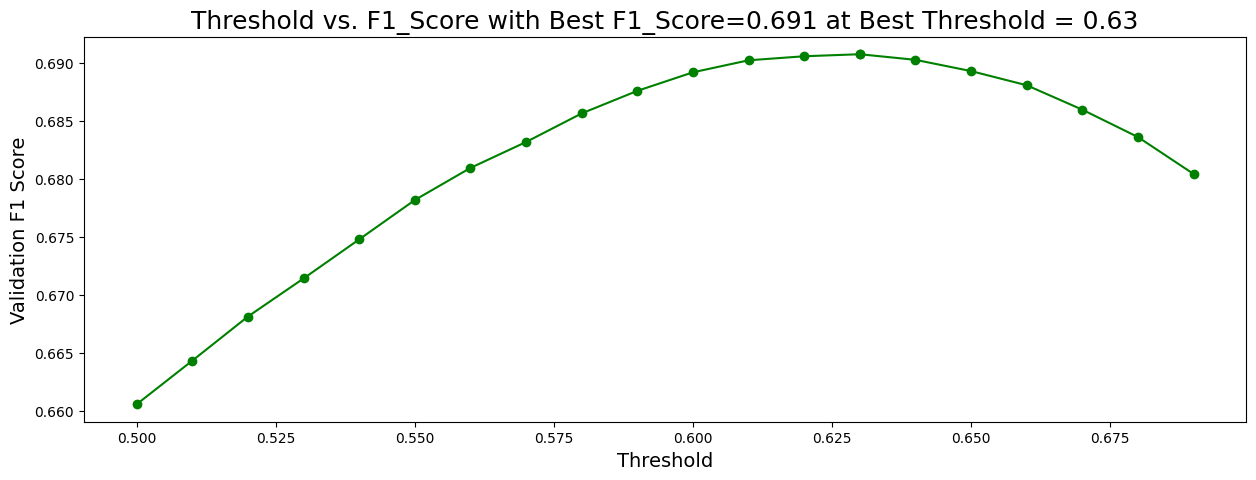

When using optimal threshold = 0.63...
Q0: F1 = 0.6603537916754433
Q1: F1 = 0.49658540190662925
Q2: F1 = 0.5197439200339536
Q3: F1 = 0.6618341166860363
Q4: F1 = 0.6194805957064079
Q5: F1 = 0.6290152594055254
Q6: F1 = 0.6224429078261225
Q7: F1 = 0.552730890528753
Q8: F1 = 0.6225387114409436
Q9: F1 = 0.5472251081101056
Q10: F1 = 0.6051062424594142
Q11: F1 = 0.5046104951012286
Q12: F1 = 0.4566270539878872
Q13: F1 = 0.6298754942523273
Q14: F1 = 0.5649653444568608
Q15: F1 = 0.4810252061835252
Q16: F1 = 0.5432767835520845
Q17: F1 = 0.49235815399352756
==> Overall F1 = 0.6907323418491653
s


In [41]:
for threshold in np.arange(0.5, 0.7, 0.01):
    preds = (oof.values.reshape(-1) > threshold).astype('int')
    m = f1_score(true.values.reshape(-1), preds, average='macro')
    scores.append(m)
    thresholds.append(threshold)
    if m > best_socre:
        best_socre = m
        best_threshold = threshold

plt.figure(figsize=(15, 5))
plt.plot(thresholds, scores, '-o', color='green')
plt.scatter([best_threshold], [best_socre], color='green')
plt.xlabel("Threshold", size=14)
plt.ylabel("Validation F1 Score",size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score={best_socre:.3f} at Best Threshold = {best_threshold:.3}', size=18)
plt.show()

print(f'When using optimal threshold = {best_threshold:.2f}...')
for k in range(18):
    m = f1_score(true[k].values, (oof[k].values > best_threshold).astype('int'), average = 'macro')
    print(f'Q{k}: F1 =',m)
m = f1_score(true.values.reshape(-1), (oof.values > best_threshold).reshape(-1).astype('int'), average = 'macro')
print('==> Overall F1 =', m)
print('s')

# Submission Jo Wilder

In [42]:
import jo_wilder_310 as jo_wilder
env = jo_wilder.make_env()
iter_test = env.iter_test()

In [43]:
models_list = [[CatBoostClassifier().load_model(
    f"fold{fold}_q{q}.cbm"
) for fold in range(2)] for q in range(1, 19)]

In [44]:
limits = {'0-4':(1,4), '5-12':(4,14), '13-22':(14,19)}

for test, sample_submission in iter_test:
    sample_submission['question'] = [int(label.split('_')[1][1:]) for label in sample_submission['session_id']]
    grp = test.level_group.values[0]
    session_id = test.session_id.values[0]
    a,b = limits[grp]    
        
    df = (pl.from_pandas(test)
          .drop(["fullscreen", "hq", "music"])
          .with_columns(columns))
    df = feature_engineer(df, grp, use_extra=True, feature_suffix='')
    df = time_feature(df)
    
    fold = 1
    preds = []
    a,b = limits[grp]
    
    for q in range(a, b):
        print("Question: ",q)
        FEATURES = importance_dict[str(q)]
        model = models_list[q-1][fold]
        
        pred = model.predict_proba(df[FEATURES].astype(np.float32))[:,1]
        mask = sample_submission.question == q 
        sample_submission.loc[mask, 'correct'] = (pred > best_threshold).astype('int') 

    env.predict(sample_submission[['session_id', 'correct']])

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
Question:  1
Question:  2
Question:  3
Question:  4
Question:  5
Question:  6
Question:  7
Question:  8
Question:  9
Question:  10
Question:  11
Question:  12
Question:  13
Question:  14
Question:  15
Question:  16
Question:  17
Question:  18
Question:  1
Question:  2
Question:  3
Question:  4
Question:  5
Question:  6
Question:  7
Question:  8
Question:  9
Question:  10
Question:  11
Question:  12
Question:  13
Question:  14
Question:  15
Question:  16
Question:  17
Question:  18
Question:  1
Question:  2
Question:  3
Question:  4
Question:  5
Question:  6
Question:  7
Question:  8
Question:  9
Question:  10
Question:  11
Question:  12
Question:  13
Question:  14
Question:  15
Question:  16
Question:  17
Question:  18


In [45]:
sub = pd.read_csv('submission.csv')
print("Shape: ",sub.shape)
sub1 = sub[sub["session_id"].str.contains("session_id") == False]
print("Shape: ",sub1.shape)
sub1["correct"] = pd.to_numeric(sub1["correct"], downcast="float")
print("==> Test MEAN: ",np.mean(sub1["correct"]))
sub1.head(18)

Shape:  (54, 2)
Shape:  (54, 2)
==> Test MEAN:  0.5925926


session_id  correct
0    20090109393214576_q1      1.0
1    20090109393214576_q2      1.0
2    20090109393214576_q3      1.0
3    20090109393214576_q4      1.0
4    20090109393214576_q5      0.0
5    20090109393214576_q6      1.0
6    20090109393214576_q7      1.0
7    20090109393214576_q8      0.0
8    20090109393214576_q9      1.0
9   20090109393214576_q10      0.0
10  20090109393214576_q11      0.0
11  20090109393214576_q12      1.0
12  20090109393214576_q13      0.0
13  20090109393214576_q14      1.0
14  20090109393214576_q15      0.0
15  20090109393214576_q16      1.0
16  20090109393214576_q17      1.0
17  20090109393214576_q18      1.0